# TGAT for Network Intrusion Detection (Refactored - Using CustomTemporalLoader)

This notebook implements a Temporal Graph Attention Network (TGAT) using PyTorch Geometric and PyTorch Geometric Temporal.

**Goal:** Achieve higher training efficiency by using a custom temporal neighbor loader for batching and neighbor sampling.

**Structure:**
1. Setup & Configuration
2. Utilities
3. Custom Temporal Loader Implementation
4. Data Loading & Preprocessing
5. Model Definition (TGAT - Adapted for Batch Processing)
6. Training (Using Custom Temporal Loader)
7. Evaluation (Using Custom Temporal Loader)
8. Main Execution

## 1. Setup & Configuration

In [2]:
# --- Environment Setup ---
# Make sure torch is installed first if not already
# %pip install torch torchvision torchaudio
import torch
import os

%pip install --upgrade pip setuptools wheel

# Install PyTorch Geometric core dependencies (adjust torch version and cuda suffix as needed)
TORCH_VERSION = torch.__version__.split('+')[0] # Get base torch version
CUDA_VERSION = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'
CUDA_SUFFIX = f'cu{CUDA_VERSION}' if CUDA_VERSION != 'cpu' else 'cpu'
print(f"Installing PyG dependencies for Torch {TORCH_VERSION} and CUDA {CUDA_SUFFIX}...")
%pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_SUFFIX}.html

# --- Install pyg-lib for potential speedup (addresses warning) ---
print(f"Installing pyg-lib for Torch {TORCH_VERSION} and CUDA {CUDA_SUFFIX}...")
%pip install pyg_lib -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_SUFFIX}.html
# ------------------------------------------------------------------

%pip install "torch_geometric==2.6.1"
%pip install "torch-geometric-temporal==0.56.0"

# Other necessary libraries
%pip install pandas numpy scikit-learn matplotlib seaborn tqdm requests

Note: you may need to restart the kernel to use updated packages.
Installing PyG dependencies for Torch 2.1.1 and CUDA cu121...
Looking in links: https://data.pyg.org/whl/torch-2.1.1+cu121.html
Note: you may need to restart the kernel to use updated packages.
Installing pyg-lib for Torch 2.1.1 and CUDA cu121...
Looking in links: https://data.pyg.org/whl/torch-2.1.1+cu121.html
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- Configuration (Ensure imports are done after installation) ---
import logging
# Set logging level to DEBUG to see more detailed messages
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Re-import torch after potential updates ---
import torch

# --- Data Paths & URLs ---
BASE_DIR = '.'
DATA_DIR = os.path.join(BASE_DIR, 'data')
TRAIN_FILE_ORIG = 'KDDTrain+_20Percent.txt'
TEST_FILE_ORIG = 'KDDTest+.txt'
TRAIN_PATH_ORIG = os.path.join(DATA_DIR, TRAIN_FILE_ORIG)
TEST_PATH_ORIG = os.path.join(DATA_DIR, TEST_FILE_ORIG)

NSL_KDD_TRAIN_URL = "https://raw.githubusercontent.com/jmnwong/NSL-KDD-Dataset/refs/heads/master/KDDTrain%2B_20Percent.txt"
NSL_KDD_TEST_URL = "https://raw.githubusercontent.com/jmnwong/NSL-KDD-Dataset/refs/heads/master/KDDTest%2B.txt"

# --- Preprocessing ---
CATEGORICAL_FEATURES = ['protocol_type', 'service', 'flag']
# NODE_ID_COLS are no longer needed for defining nodes in this new structure
# NODE_ID_COLS_SRC = ['protocol_type', 'src_bytes'] # Keep if needed for edge definition later
# NODE_ID_COLS_DST = ['service', 'dst_bytes'] # Keep if needed for edge definition later

# --- Model Hyperparameters ---
NODE_FEAT_DIM = None # Set dynamically based on processed features
EDGE_FEAT_DIM = None # Set dynamically based on edge features (if any)
# TIME_DIM = 64
TIME_DIM = 128
NUM_CLASSES = None # Set dynamically (e.g., 2 for binary, more for multi-class)
N_HEADS = 2
N_LAYERS = 2
DROPOUT = 0.1
# HIDDEN_DIM = 128 # Specify a hidden dimension, e.g., 128
HIDDEN_DIM = 256

# --- Training Parameters ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50 # Increase epochs maybe
# BATCH_SIZE = 128
BATCH_SIZE = 256
NUM_NEIGHBORS = [10] # How many temporal neighbors (previous events) to sample
# LEARNING_RATE = 0.0005 # Possibly lower learning rate
LEARNING_RATE = 0.005
# POS_WEIGHT logic needs to be recalculated based on node labels if doing binary
POS_WEIGHT = torch.tensor([1.0], device=DEVICE)

# --- Evaluation ---
THRESHOLD = 0.5 # For binary classification conversion

print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Utilities

In [4]:
# --- Utility Functions --- 
import torch
import os
import requests
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_device():
    """Gets the available computation device (GPU or CPU)."""
    if torch.cuda.is_available():
        logging.info("CUDA detected, using GPU.")
        return torch.device('cuda')
    else:
        logging.info("CUDA not detected, using CPU.")
        return torch.device('cpu')

def download_file(url, dest_folder, filename):
    """Downloads a file if it doesn't exist."""
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    filepath = os.path.join(dest_folder, filename)
    if not os.path.exists(filepath):
        logging.info(f"Downloading {filename} from {url}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() 
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            logging.info(f"{filename} downloaded successfully.")
        except requests.exceptions.RequestException as e:
            logging.error(f"Error downloading {filename}: {e}")
            raise
    else:
        logging.info(f"{filename} already exists, skipping download.")

# Set DEVICE config variable
DEVICE = get_device()
POS_WEIGHT = torch.tensor([1.0], device=DEVICE)

2025-05-14 03:49:24,718 - INFO - CUDA detected, using GPU.


## 3. Custom Temporal Loader Implementation
注意： 這個版本假設圖結構（節點=事件，邊=連續）和標籤都在主 TemporalData 物件中定義好了。它只負責將底層 NeighborLoader 返回的批次（現在包含正確的節點級別 x 和 y）傳遞出去，並添加必要的屬性（如果層需要的話，但我們簡化了層，所以可能不需要 edge_t, edge_msg 了）。

In [5]:
# --- Custom Temporal Loader (Event-as-Node, Final Fix for __init__) ---
import torch
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data, TemporalData # Ensure both are imported
from typing import Any
import logging

class TemporalNeighborLoader(NeighborLoader):
    """
    Loads temporal graphs where nodes represent events.
    Inherits from NeighborLoader for node-based sampling.
    FIXED: Converts input TemporalData to Data (without y) for base loader.
           Manually extracts correct target node labels y in postprocessing.
           Ensured 'node_time_attr' is NOT passed to super().__init__.
    """
    # Removed node_time_attr from this method's signature as well
    def __init__(self, data, batch_size=1, num_neighbors=None, replace=False, directed=True,
                 input_nodes=None, **kwargs): # REMOVED node_time_attr='t' from here

        if not isinstance(data, TemporalData):
             raise TypeError("Input data must be a TemporalData object for TemporalNeighborLoader.")

        # Check required attributes
        required = ['x', 't', 'y', 'edge_index']
        if any(not hasattr(data, attr) for attr in required):
            raise ValueError(f"Input data missing one of required attributes: {required}")
        if data.num_nodes is None: data.num_nodes = data.x.size(0)

        logging.info(f"Initializing TemporalNeighborLoader for Event-as-Node graph with {data.num_nodes} nodes.")
        logging.debug(f"Input TemporalData shapes: x={data.x.shape}, t={data.t.shape}, y={data.y.shape}, edge_index={data.edge_index.shape}")

        # --- Convert TemporalData to standard PyG Data for NeighborLoader ---
        # *** DO NOT include 'y' here; we will add it manually later ***
        pyg_data = Data(
            x=data.x,
            edge_index=data.edge_index,
            t=data.t,           # Node time added as 't' attribute to the Data object
            num_nodes=data.num_nodes
        )
        if hasattr(data, 'msg') and data.msg is not None:
             pyg_data.edge_attr = data.msg

        logging.debug(f"Converted to PyG Data object (without y): {pyg_data}")
        # --------------------------------------------------------------------

        # --- Store original y labels and node feature dim ---
        self.original_data_y = data.y.clone() # Store all original labels
        self.y_dtype = self.original_data_y.dtype # Store dtype for later use
        self.node_feature_dim = data.x.size(1) if data.x is not None else 0
        # ----------------------------------------------------

        # Handle kwargs for neighbor sampling
        if 'num_neighbors' in kwargs and num_neighbors is None: num_neighbors = kwargs.pop('num_neighbors')
        if 'replace' in kwargs and replace is None: replace = kwargs.pop('replace', False)
        if 'directed' in kwargs and directed is None: directed = kwargs.pop('directed', True)

        # Set input nodes for sampling
        if input_nodes is None:
            input_nodes = torch.arange(data.num_nodes)
        elif isinstance(input_nodes, torch.Tensor) and input_nodes.dtype == torch.bool:
            input_nodes = input_nodes.nonzero(as_tuple=False).view(-1)

        # ---- Call parent NeighborLoader __init__ ----
        # *** ENSURE node_time_attr IS NOT PASSED HERE ***
        super().__init__(
            data=pyg_data,
            num_neighbors=num_neighbors,
            batch_size=batch_size,
            input_nodes=input_nodes,
            replace=replace,
            directed=directed,
            # ** Any arguments needed by base DataLoader (like num_workers) **
            # ** should be passed via **kwargs from the train_model_event_node call **
            **kwargs
        )
        logging.info(f"TemporalNeighborLoader initialized successfully.")


    def _temporal_postprocess_batch(self, batch):
        """Manually add the correct target node labels 'y' and check 't'."""
        logging.debug(f"Postprocessing batch: Contains keys: {list(batch.keys())}")

        if not hasattr(batch, 'x') or batch.x is None:
            logging.error("Postprocess: Batch missing 'x'. Cannot proceed.")
            return None
        if not hasattr(batch, 'n_id') or batch.n_id is None:
            logging.error("Postprocess: Batch missing 'n_id'. Cannot fetch labels.")
            return None
        if not hasattr(batch, 'batch_size') or batch.batch_size is None:
            logging.error("Postprocess: Batch missing 'batch_size'. Cannot determine target count.")
            return None

        B = batch.batch_size
        N = batch.x.size(0)

        # --- Manually Fetch Correct Labels 'y' ---
        if batch.n_id.numel() < B:
             logging.error(f"Postprocess: n_id size ({batch.n_id.numel()}) < batch_size ({B}).")
             return None
        target_original_indices = batch.n_id[:B]
        if target_original_indices.max() >= self.original_data_y.size(0):
             logging.error(f"Postprocess: Max target node index ({target_original_indices.max()}) out of bounds for original labels.")
             return None
        correct_y = self.original_data_y[target_original_indices].clone()
        batch.y = correct_y.to(dtype=self.y_dtype)
        # ----------------------------------------

        # Ensure node time 't' is present
        if not hasattr(batch, 't'):
            logging.warning("Batch missing node time 't' after loading. Model might fail.")
            batch.t = torch.zeros(N, dtype=torch.long, device=batch.x.device)
        elif batch.t.size(0) != N: # Add check for correct size if 't' exists
             logging.error(f"Postprocess: node time 't' size ({batch.t.size(0)}) != node features 'x' size ({N}).")
             return None


        if not hasattr(batch, 'num_sampled_nodes'):
            batch.num_sampled_nodes = torch.tensor([N])

        logging.debug(f"Finished Postprocessing: N={N}, B={B}, x={batch.x.shape}, Added y={batch.y.shape}, t={batch.t.shape}")

        # Final check
        if batch.y.size(0) != B:
             logging.error(f"Internal Error after postprocessing: batch.y size ({batch.y.size(0)}) != B ({B}).")
             return None

        return batch

    def __iter__(self):
        parent_iter = super().__iter__()
        for i, batch in enumerate(parent_iter):
            logging.debug(f"Processing batch {i} from parent loader.")
            processed_batch = self._temporal_postprocess_batch(batch)
            if processed_batch is None:
                 logging.error(f"Skipping batch {i} due to postprocessing error.")
                 continue
            required = ['x', 'y', 't', 'edge_index', 'num_sampled_nodes']
            if any(not hasattr(processed_batch, attr) or getattr(processed_batch, attr) is None for attr in required):
                 logging.error(f"Batch {i} missing essential attributes after postprocessing. Skipping.")
                 continue
            if processed_batch.y.size(0) > processed_batch.x.size(0):
                 logging.error(f"Batch {i} labels > nodes. Skipping.")
                 continue
            if processed_batch.t.size(0) != processed_batch.x.size(0):
                logging.error(f"Batch {i} time size != node feature size. Skipping.")
                continue

            logging.debug(f"Yielding processed batch {i}")
            yield processed_batch

## 4. Data Loading & Preprocessing
注意: 這個版本創建了一個 TemporalData 物件，其中每個事件是一個節點，邊僅連接連續的事件。

In [6]:
# --- Data Loading and Preprocessing (Revised: Event as Node, with COL_NAMES and load_nsl_kdd) ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from torch_geometric.data import TemporalData # Use TemporalData again
import logging
import os
import torch # Ensure torch is imported

# Assume download_file is defined in Utilities cell (Cell 4)
# Assume DEVICE is defined in setup cell
# Assume TRAIN_PATH_ORIG, TEST_PATH_ORIG are defined in setup cell
# Assume CATEGORICAL_FEATURES is defined in setup cell

# --- Define Column Names (Moved from original Cell 6) ---
COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
             "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
             "logged_in","num_compromised","root_shell","su_attempted","num_root",
             "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate",
             "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
             "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
             "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "difficulty"]

# --- Function to load the raw data ---
def load_nsl_kdd(train_path, test_path):
    logging.info("Loading NSL-KDD dataset...")
    global COL_NAMES # Ensure function can access the global COL_NAMES
    try:
        # Assuming download_file is available globally or defined earlier
        # download_file(NSL_KDD_TRAIN_URL, DATA_DIR, TRAIN_FILE_ORIG) # If download is needed
        # download_file(NSL_KDD_TEST_URL, DATA_DIR, TEST_FILE_ORIG)
        df_train_orig = pd.read_csv(train_path, header=None, names=COL_NAMES)
        df_test_orig = pd.read_csv(test_path, header=None, names=COL_NAMES)
        logging.info(f"Original training set shape: {df_train_orig.shape}")
        logging.info(f"Original test set shape: {df_test_orig.shape}")
        return df_train_orig, df_test_orig
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

# --- Label Preprocessing (Binary + Multi-class) ---
def preprocess_labels_event_node(df):
    logging.info("Processing labels (Event as Node)...")
    if 'attack' not in df.columns: raise KeyError("Missing 'attack' column")

    # Binary label
    df['binary_attack'] = (df['attack'] != 'normal').astype(int)

    # Multi-class label (Example mapping, adjust as needed)
    attack_map = {
        'normal': 'normal', 'back': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'smurf': 'dos', 'teardrop': 'dos',
        'ipsweep': 'probe', 'nmap': 'probe', 'portsweep': 'probe', 'satan': 'probe',
        'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'multihop': 'r2l', 'phf': 'r2l', 'spy': 'r2l', 'warezclient': 'r2l', 'warezmaster': 'r2l',
        'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r',
        # Add other attacks from KDDTest+ if necessary (e.g., from 'difficulty' column analysis or external knowledge)
        'mailbomb': 'dos', 'apache2': 'dos', 'processtable': 'dos', 'udpstorm': 'dos',
        'mscan': 'probe', 'saint': 'probe',
        'sendmail': 'r2l', 'named': 'r2l', 'snmpgetattack': 'r2l', 'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'r2l',
        'httptunnel': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'xterm': 'u2r'
    }
    df['attack_category'] = df['attack'].map(attack_map).fillna('other_attack') # Map known, fill unknown as 'other'
    label_encoder = LabelEncoder()
    df['attack_label_encoded'] = label_encoder.fit_transform(df['attack_category'])
    num_classes = len(label_encoder.classes_)

    logging.info(f"Binary label distribution:\n{df['binary_attack'].value_counts(normalize=True)}")
    logging.info(f"Multi-class label distribution:\n{df['attack_category'].value_counts(normalize=True)}")
    logging.info(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

    df_out = df[['binary_attack', 'attack_label_encoded']].copy() # Keep only label columns needed

    return df_out, label_encoder, num_classes

# --- Feature Preprocessing ---
def preprocess_features_event_node(df_train, df_test, categorical_features_list):
    logging.info("Preprocessing features (Event as Node)...")
    # Combine train and test for consistent preprocessing
    # Keep original timestamp if present
    keep_cols = ['timestamp'] if 'timestamp' in df_train.columns else []
    df_train_feat = df_train.drop(columns=['attack', 'difficulty'] + [c for c in keep_cols if c in df_train.columns], errors='ignore').copy()
    df_test_feat = df_test.drop(columns=['attack', 'difficulty'] + [c for c in keep_cols if c in df_test.columns], errors='ignore').copy()

    # Store timestamps separately
    train_timestamps = df_train['timestamp'].values if 'timestamp' in df_train.columns else np.arange(len(df_train))
    test_timestamps = df_test['timestamp'].values if 'timestamp' in df_test.columns else np.arange(len(df_train), len(df_train) + len(df_test))

    df_combined_feat = pd.concat([df_train_feat, df_test_feat], ignore_index=True)

    categorical_features = [col for col in categorical_features_list if col in df_combined_feat.columns]
    numerical_features = df_combined_feat.select_dtypes(include=np.number).columns.tolist()

    if 'num_outbound_cmds' in numerical_features:
        if df_combined_feat['num_outbound_cmds'].nunique() <= 1:
            logging.info("Removing constant or near-constant 'num_outbound_cmds' column")
            numerical_features.remove('num_outbound_cmds')
            df_combined_feat = df_combined_feat.drop(['num_outbound_cmds'], axis=1, errors='ignore')

    preprocessor = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
                      ('num', StandardScaler(), numerical_features)],
        remainder='drop' # Drop any remaining columns not used as features
    )

    logging.info("Fitting and transforming features...")
    processed_features_array = preprocessor.fit_transform(df_combined_feat)

    # Get feature names after transformation
    try:
        ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    except AttributeError:
        num_ohe_features = processed_features_array.shape[1] - len(numerical_features)
        ohe_feature_names = [f"cat_{i}" for i in range(num_ohe_features)]
        logging.warning("Using generic names for OHE features.")

    final_node_feature_names = list(ohe_feature_names) + numerical_features
    feature_dim = len(final_node_feature_names)
    logging.info(f"Final feature dimension (node_feat_dim): {feature_dim}")

    # Split back into train/test processed features
    num_train = len(df_train_feat)
    train_features_processed = processed_features_array[:num_train]
    test_features_processed = processed_features_array[num_train:]

    return train_features_processed, test_features_processed, train_timestamps, test_timestamps, preprocessor, feature_dim


# --- Graph Construction (Event as Node, Sequential Edges) ---
def create_event_node_temporal_data(features, labels, timestamps, use_binary_label=True):
    num_events = features.shape[0]
    if num_events == 0:
         logging.warning("No events found to create TemporalData.")
         return TemporalData() # Return empty if no events

    x = torch.tensor(features, dtype=torch.float)
    label_col = 'binary_attack' if use_binary_label else 'attack_label_encoded'
    if label_col not in labels.columns:
         raise ValueError(f"Label column '{label_col}' not found in labels DataFrame.")
    # Ensure correct dtype based on loss function
    y_dtype = torch.float if use_binary_label else torch.long
    y = torch.tensor(labels[label_col].values, dtype=y_dtype)

    t = torch.tensor(timestamps, dtype=torch.long)

    if num_events > 1:
        src = torch.arange(0, num_events - 1)
        dst = torch.arange(1, num_events)
        edge_index = torch.stack([src, dst], dim=0)
        logging.info(f"Created sequential edges: {edge_index.shape[1]} edges.")
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        logging.info("Only one event, no sequential edges created.")

    data = TemporalData(
        x=x,       # Node features = Event features
        edge_index=edge_index,
        y=y,       # Node labels = Event labels
        t=t,       # Node time = Event time
        num_nodes=num_events
    )
    logging.info(f"Event-as-Node TemporalData created: {data}")
    logging.debug(f"Data shapes: x={data.x.shape}, edge_index={data.edge_index.shape}, y={data.y.shape}, t={data.t.shape}")
    return data

# --- Main Data Loading Pipeline (REVISED for Event-as-Node) ---
def load_and_preprocess_data_event_node_pipeline(use_binary_classification=False):
    # **Call the load function first**
    df_train_orig, df_test_orig = load_nsl_kdd(TRAIN_PATH_ORIG, TEST_PATH_ORIG)

    # Add timestamps if needed
    if 'timestamp' not in df_train_orig.columns:
         df_train_orig['timestamp'] = np.arange(len(df_train_orig))
         logging.info("Added sequential timestamps to training data.")
    if 'timestamp' not in df_test_orig.columns:
         df_test_orig['timestamp'] = np.arange(len(df_train_orig), len(df_train_orig) + len(df_test_orig))
         logging.info("Added sequential timestamps to test data.")

    # Preprocess labels (for both train and test together initially for consistent encoding)
    df_all_orig_for_labels = pd.concat([df_train_orig, df_test_orig], ignore_index=True).copy()
    df_all_labels, label_encoder, num_classes = preprocess_labels_event_node(df_all_orig_for_labels)

    # Preprocess features (Pass original dfs to preserve timestamp if needed)
    train_features, test_features, train_timestamps, test_timestamps, preprocessor, feature_dim = preprocess_features_event_node(
        df_train_orig, df_test_orig, CATEGORICAL_FEATURES
    )

    # Combine all features, labels, timestamps
    all_features = np.concatenate([train_features, test_features], axis=0)
    all_labels_df = df_all_labels # Contains binary and encoded multi-class labels
    all_timestamps = np.concatenate([train_timestamps, test_timestamps])

    # Create the single TemporalData object
    data = create_event_node_temporal_data(
        all_features,
        all_labels_df,
        all_timestamps,
        use_binary_label=use_binary_classification
    )

    # Create train/test masks based on original number of events
    num_train_events = len(df_train_orig)
    num_test_events = len(df_test_orig)
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[:num_train_events] = True
    test_mask[num_train_events:] = True
    data.train_mask = train_mask
    data.test_mask = test_mask
    data.label_encoder = label_encoder # Attach encoder for later use

    # Update global config
    global NODE_FEAT_DIM, NUM_CLASSES, EDGE_FEAT_DIM
    NODE_FEAT_DIM = feature_dim
    EDGE_FEAT_DIM = 0 # Since sequential edges have no features currently
    NUM_CLASSES = 2 if use_binary_classification else num_classes

    # Calculate pos_weight for binary case
    if use_binary_classification:
        y_train_binary = data.y[data.train_mask].float() # Ensure float for calculation
        neg = (y_train_binary == 0).sum().item()
        pos = (y_train_binary == 1).sum().item()
        global POS_WEIGHT
        if pos > 0:
            POS_WEIGHT = torch.tensor([float(neg) / pos], device=DEVICE)
            logging.info(f"Calculated pos_weight for binary task: {POS_WEIGHT.item():.4f}")
        else:
            POS_WEIGHT = torch.tensor([1.0], device=DEVICE)
            logging.warning("No positive samples in binary training data, using pos_weight=1.0")
    else:
        POS_WEIGHT = torch.tensor([1.0], device=DEVICE)


    return data, preprocessor, label_encoder

## 5. Model Definition (TGAT - Adapted for Batch Processing)
注意： 這個版本簡化了 TemporalGraphAttentionLayer，使其不再依賴邊特徵 (edge_msg)，因為我們的邊（連續事件）目前沒有明確的特徵。注意力計算現在基於節點（事件）特徵和時間。

In [7]:
# --- TGAT Model Definition (Event as Node - FINAL N Fix & Error Handling) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.inits import glorot, zeros
import numpy as np
import logging

# Configure logging for slightly cleaner output
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')

try:
    from torch_scatter import scatter_add, scatter_softmax
    _torch_scatter_available = True
except ImportError:
    _torch_scatter_available = False
    logging.error("torch_scatter not found!")

# --- FunctionalTimeEncoder (Unchanged) ---
class FunctionalTimeEncoder(nn.Module):
    def __init__(self, d_model):
        super(FunctionalTimeEncoder, self).__init__()
        self.d_model = d_model
        self.omega = nn.Parameter(torch.randn(d_model // 2))
    def forward(self, t):
        # ... (implementation remains the same) ...
        if t.ndim == 0: t = t.unsqueeze(0)
        if t.ndim == 1: t = t.unsqueeze(-1)
        t = t.float()
        omega_device = self.omega.to(t.device)
        args = omega_device * t
        cos_t = torch.cos(args)
        sin_t = torch.sin(args)
        norm_factor = torch.sqrt(torch.tensor(self.d_model / 2.0, device=t.device, dtype=torch.float))
        if norm_factor == 0: norm_factor = 1.0; logging.warning("FTE: Norm factor is zero.")
        phi_t = torch.cat([cos_t, sin_t], dim=-1) / norm_factor
        if torch.isnan(phi_t).any() or torch.isinf(phi_t).any():
            logging.error("FTE: NaN/Inf detected.")
            return torch.zeros(t.shape[0], self.d_model, device=t.device)
        return phi_t

# --- TemporalGraphAttentionLayer (Simplified, no edge_msg) ---
class TemporalGraphAttentionLayer(nn.Module):
    def __init__(self, node_feat_dim, time_dim, n_heads, out_dim, dropout=0.1):
        super(TemporalGraphAttentionLayer, self).__init__()
        if not _torch_scatter_available: raise ImportError("torch_scatter required!")
        self.node_feat_dim = node_feat_dim
        self.time_dim = time_dim
        self.n_heads = n_heads
        self.out_dim = out_dim
        self.dropout = dropout
        self.head_dim = out_dim // n_heads
        if self.head_dim * n_heads != out_dim: logging.warning(f"Layer {self}: out_dim {out_dim} not divisible by n_heads {n_heads}.")
        self.time_encoder = FunctionalTimeEncoder(time_dim)
        kv_input_dim = node_feat_dim + time_dim
        q_input_dim = node_feat_dim
        self.W_q = nn.Linear(q_input_dim, out_dim)
        self.W_k = nn.Linear(kv_input_dim, out_dim)
        self.W_v = nn.Linear(kv_input_dim, out_dim)
        self.W_o = nn.Linear(out_dim, out_dim)
        self.residual_proj = nn.Identity()
        if node_feat_dim != out_dim: self.residual_proj = nn.Linear(node_feat_dim, out_dim); logging.debug(f"Layer {self}: Added residual projection {node_feat_dim} -> {out_dim}")
        self.layer_norm1 = nn.LayerNorm(out_dim)
        self.ffn = nn.Sequential(nn.Linear(out_dim, out_dim * 4), nn.ReLU(), nn.Dropout(dropout), nn.Linear(out_dim * 4, out_dim))
        self.layer_norm2 = nn.LayerNorm(out_dim)
        self.out_dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, t, size):
        N, _ = size
        if N <= 0: logging.warning("Layer Norm 1 Start: N=0"); return torch.zeros((0, self.out_dim), device=x.device)

        if edge_index.numel() > 0:
            if edge_index.min() < 0 or edge_index.max().item() >= N:
                logging.error(f"Layer Norm 1 Error: Invalid edge_index! max={edge_index.max().item()}, N={N}. Returning None.")
                return None # Signal error
        if t.size(0) != N:
             logging.error(f"Layer Norm 1 Error: Time tensor size {t.size(0)} != N {N}. Returning None.")
             return None

        Q = self.W_q(x).view(N, self.n_heads, self.head_dim)
        if edge_index.numel() > 0:
            source_nodes, target_nodes = edge_index[0], edge_index[1]
            x_source = x[source_nodes]
            t_source, t_target = t[source_nodes], t[target_nodes]
            delta_t = t_target - t_source
            rel_t_enc = self.time_encoder(delta_t)
            if torch.isnan(rel_t_enc).any(): logging.error("NaN in time encoding!"); return None
            kv_input = torch.cat([x_source, rel_t_enc], dim=-1)
            K = self.W_k(kv_input).view(-1, self.n_heads, self.head_dim)
            V = self.W_v(kv_input).view(-1, self.n_heads, self.head_dim)
            Q_expanded = Q[target_nodes]
            attn_scores = (Q_expanded * K).sum(dim=-1) / np.sqrt(self.head_dim)
            # Use dim_size=N for scatter operations targeting nodes 0..N-1
            attn_weights = scatter_softmax(attn_scores, target_nodes, dim=0, dim_size=N)
            V_weighted = V * attn_weights.unsqueeze(-1)
            aggregated_neighbors = scatter_add(V_weighted, target_nodes, dim=0, dim_size=N)
        else:
            aggregated_neighbors = torch.zeros(N, self.n_heads, self.head_dim, device=x.device)

        out_agg = self.W_o(aggregated_neighbors.view(N, -1))
        x_res = self.residual_proj(x)
        out = self.layer_norm1(out_agg + x_res)
        out_ffn = self.ffn(out)
        out = self.layer_norm2(out + out_ffn)
        out = self.out_dropout(out)
        # Removed repetitive logging from layer forward
        return out


# 3. TGAT Model (Event as Node - Final Fix for N & Error Handling)
class TGAT(nn.Module):
    def __init__(self, num_nodes, node_feat_dim, time_dim, output_dim,
                 n_layers=2, n_heads=2, dropout=0.1, hidden_dim=None):
        super(TGAT, self).__init__()
        # ... (initialization remains the same) ...
        if num_nodes <= 0: raise ValueError("num_nodes must be positive.")
        self.num_nodes = num_nodes
        self.node_feat_dim = node_feat_dim
        self.time_dim = time_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout
        raw_hidden_dim = hidden_dim if hidden_dim is not None else self.node_feat_dim
        if self.node_feat_dim == 0:
             raw_hidden_dim = hidden_dim if hidden_dim is not None else 64
             logging.warning(f"Node_feat_dim=0. Using hidden_dim={raw_hidden_dim}")
        if raw_hidden_dim % self.n_heads != 0:
            self.hidden_dim = (raw_hidden_dim // self.n_heads + 1) * self.n_heads
            logging.warning(f"Adjusted hidden_dim from {raw_hidden_dim} to {self.hidden_dim}")
        else: self.hidden_dim = raw_hidden_dim
        if self.node_feat_dim > 0:
             self.initial_proj = nn.Linear(self.node_feat_dim, self.hidden_dim)
             current_node_dim = self.hidden_dim
             self.node_emb = None
        else:
             logging.info(f"Using nn.Embedding for nodes as node_feat_dim=0.")
             self.node_emb = nn.Embedding(num_nodes, self.hidden_dim)
             self.initial_proj = None
             current_node_dim = self.hidden_dim
        logging.info(f"TGAT: Start node dim={current_node_dim}")
        self.tgat_layers = nn.ModuleList()
        current_in_dim = current_node_dim
        for i in range(n_layers):
            layer_out_dim = self.hidden_dim
            if layer_out_dim % self.n_heads != 0: layer_out_dim = (layer_out_dim // self.n_heads + 1) * self.n_heads
            logging.info(f"TGAT: Layer {i}: in={current_in_dim}, out={layer_out_dim}, heads={n_heads}")
            self.tgat_layers.append(
                TemporalGraphAttentionLayer(
                    node_feat_dim=current_in_dim, time_dim=self.time_dim, n_heads=self.n_heads,
                    out_dim=layer_out_dim, dropout=self.dropout))
            current_in_dim = layer_out_dim
        self.final_proj = nn.Linear(current_in_dim, self.output_dim)
        logging.info(f"TGAT: Final projection: {current_in_dim} -> {self.output_dim}")


    def forward(self, batch):
        """Processes a batch where nodes are events."""
        required_attrs = ['x', 't', 'y', 'edge_index']
        if any(not hasattr(batch, attr) or getattr(batch, attr) is None for attr in required_attrs):
            missing = [attr for attr in required_attrs if not hasattr(batch, attr) or getattr(batch, attr) is None]
            logging.error(f"TGAT Fwd Error: Batch missing attribute(s): {missing}")
            return None

        # --- Directly get N from x, B from y ---
        try:
            if batch.x is None: raise ValueError("batch.x is None")
            if batch.y is None: raise ValueError("batch.y is None")
            N = batch.x.size(0)
            B = batch.y.size(0) # B is the number of target nodes in the batch
        except Exception as e:
            logging.error(f"TGAT Fwd Error: Failed to get N/B: {e}")
            return None

        if N == 0: logging.warning("TGAT Fwd: N=0, cannot proceed."); return None
        if B == 0: logging.warning("TGAT Fwd: B=0, returning empty tensor."); return torch.empty((0, self.output_dim), device=batch.x.device if batch.x is not None else torch.device('cpu'))

        logging.debug(f"TGAT Fwd Start: N={N}, B={B}, x={batch.x.shape if batch.x is not None else 'None'}")
        size = (N, N)
        x, edge_index, t, y = batch.x, batch.edge_index, batch.t, batch.y

        # --- Input Validation ---
        if edge_index.numel() > 0:
            edge_max_idx = edge_index.max().item()
            if edge_index.min() < 0 or edge_max_idx >= N:
                # Use the *correct N* in the log message
                logging.error(f"TGAT Fwd Error: Invalid edge_index! min={edge_index.min()}, max={edge_max_idx}, N={N}")
                return None
        if t.size(0) != N:
            logging.error(f"TGAT Fwd Error: Node time 't' size ({t.size(0)}) != N ({N})")
            return None
        # --------------------------

        # --- Initial Node Embeddings ---
        if self.initial_proj is not None:
            if x.size(1) != self.node_feat_dim:
                logging.error(f"TGAT Fwd Error: Input x dim ({x.size(1)}) != model node_feat_dim ({self.node_feat_dim})")
                return None
            h = self.initial_proj(x)
        else:
            if self.node_emb is None: logging.error("TGAT Fwd Error: node_emb required but not defined."); return None
            node_indices = torch.arange(N, device=edge_index.device)
            h = self.node_emb(node_indices)
        logging.debug(f"  Init h shape: {h.shape}")

        # --- Pass through TGAT Layers ---
        for i, layer in enumerate(self.tgat_layers):
            h_prev_shape = h.shape
            h = layer(h, edge_index, t, size=size) # Pass correct node time 't'
            if h is None: # Check if layer signaled an error
                logging.error(f"TGAT Fwd Error: Layer {i} returned None.")
                return None
            logging.debug(f"  After Layer {i}: h shape={h.shape}")
            if torch.isnan(h).any() or torch.isinf(h).any():
                logging.error(f"NaN/Inf after layer {i}!")
                return None

        # --- Extract Target Node Features ---
        if B > N: # Should not happen if loader is correct
            logging.error(f"Internal Error: B ({B}) > N ({N}) before h[:B] slice.")
            return None
        h_targets = h[:B] # Target nodes are the first B nodes
        logging.debug(f"  Extracted targets shape: {h_targets.shape}")

        # --- Final Projection ---
        out = self.final_proj(h_targets) # Shape [B, output_dim]
        logging.debug(f"  Final proj output shape: {out.shape}")

        # --- Final Output Validation ---
        if out.size(0) != B:
             raise RuntimeError(f"Internal Error: Final output size ({out.size(0)}) != B ({B})")
        if out.size(1) != self.output_dim:
             raise RuntimeError(f"Final output dim ({out.size(1)}) != model output_dim ({self.output_dim})")

        return out

## 6. Training & Evaluation Logic (Using Custom Temporal Loader)
注意： 主要是確保使用正確的加載器、損失函數，並傳遞正確的資料。

In [8]:
# --- Training & Evaluation Logic (Event as Node - Final Fixes) ---
import torch
import torch.optim as optim
import torch.nn as nn
import logging
from tqdm.notebook import tqdm
from torch_geometric.loader import NeighborLoader # Keep NeighborLoader import for the custom class
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- FIX: Add imports from sklearn.metrics ---
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
# ---------------------------------------------

# --- Training Epoch Function ---
def train_epoch_event_node(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_processed_nodes = 0
    num_skipped_batches = 0
    pbar = tqdm(loader, desc="Training Epoch (Event Nodes)")
    for batch in pbar:
        try:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)

            # --- Check if model output is valid for loss calculation ---
            if out is None:
                 logging.warning("Model returned None for batch. Skipping.")
                 num_skipped_batches += 1
                 continue
            # Check if the output requires gradient for backpropagation
            if not out.requires_grad:
                 logging.warning("Model output does not require grad. Skipping loss/backward.")
                 num_skipped_batches += 1
                 continue
            # ---------------------------------------------------------

            if not hasattr(batch, 'y') or batch.y is None:
                 logging.warning("Batch missing 'y'. Skipping.")
                 num_skipped_batches += 1
                 continue

            ground_truth = batch.y
            # Adjust ground_truth based on criterion (same as before)
            if isinstance(criterion, nn.CrossEntropyLoss):
                if ground_truth.dim() > 1: ground_truth = ground_truth.squeeze()
                if ground_truth.dtype != torch.long: ground_truth = ground_truth.long()
            elif isinstance(criterion, nn.BCEWithLogitsLoss):
                if ground_truth.dim() == 1: ground_truth = ground_truth.unsqueeze(-1)
                if ground_truth.dtype != torch.float: ground_truth = ground_truth.float()
                if out.shape[1] != 1:
                    logging.warning(f"Output shape {out.shape} incompatible with BCE. Skipping.")
                    num_skipped_batches += 1
                    continue

            if out.shape[0] != ground_truth.shape[0]:
                 logging.warning(f"Shape mismatch: out[0] {out.shape[0]} vs gt[0] {ground_truth.shape[0]}. Skipping.")
                 num_skipped_batches += 1
                 continue

            loss = criterion(out, ground_truth)
            loss.backward()
            optimizer.step()

            batch_target_node_count = out.size(0)
            total_loss += loss.item() * batch_target_node_count
            num_processed_nodes += batch_target_node_count
            pbar.set_postfix({'loss': loss.item(), 'skipped': num_skipped_batches})

        except Exception as e:
            logging.error(f"Error processing training batch: {e}", exc_info=True)
            num_skipped_batches += 1
            continue

    if num_processed_nodes == 0:
         logging.error("No nodes processed in training epoch.")
         return None
    avg_loss = total_loss / num_processed_nodes
    if num_skipped_batches > 0: logging.warning(f"Skipped {num_skipped_batches} batches during training.")
    return avg_loss


# --- Confusion Matrix Plotting Function ---
def plot_confusion_matrix_multi(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(max(6, len(class_names)), max(5, len(class_names)*0.8))) # Adjust size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout() # Adjust layout
    plt.show()

# --- Evaluation Function ---
def evaluate_model_event_node(model, loader, device, num_classes, class_names=None, use_binary_classification=False):
    logging.info("Starting evaluation (Event as Node)...")
    model.eval()
    all_preds = []
    all_labels = []
    num_skipped_batches = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Evaluating (Event Nodes)")
        for batch in pbar:
            try:
                batch = batch.to(device)
                out = model(batch)

                if out is None:
                    logging.warning("Model returned None during eval batch. Skipping.")
                    num_skipped_batches += 1
                    continue
                if not hasattr(batch, 'y') or batch.y is None:
                    logging.warning("Batch missing 'y' during eval. Skipping.")
                    num_skipped_batches += 1
                    continue

                labels_cpu = batch.y.cpu()

                if use_binary_classification:
                     if out.shape[1] != 1: logging.warning(f"Binary eval: Output shape {out.shape} unexpected. Skip."); num_skipped_batches+=1; continue
                     pred_prob = torch.sigmoid(out).squeeze().cpu()
                     pred_binary = (pred_prob > THRESHOLD).long()
                     all_preds.append(pred_binary)
                     all_labels.append(labels_cpu.long())
                else: # Multi-class
                     if out.dim() != 2 or out.shape[1] != num_classes: logging.warning(f"Multi eval: Output shape {out.shape} unexpected. Skip."); num_skipped_batches+=1; continue
                     pred_class = out.argmax(dim=-1).cpu()
                     all_preds.append(pred_class)
                     all_labels.append(labels_cpu.long())
            except Exception as e:
                logging.error(f"Error during eval batch: {e}", exc_info=True)
                num_skipped_batches += 1
                continue

    if not all_labels or not all_preds:
        logging.error("No results collected during evaluation.")
        if num_skipped_batches > 0: logging.warning(f"Skipped {num_skipped_batches} eval batches.")
        return None

    try:
        y_true = torch.cat(all_labels).numpy()
        y_pred = torch.cat(all_preds).numpy()
    except Exception as e:
        logging.error(f"Error concatenating labels/predictions: {e}"); return None

    logging.info(f"Calculating metrics for {len(y_true)} samples...")
    if num_skipped_batches > 0: logging.warning(f"Skipped {num_skipped_batches} eval batches.")

    try:
        accuracy = accuracy_score(y_true, y_pred)
        if class_names is None: class_names = [str(i) for i in range(num_classes)]

        if use_binary_classification:
            # --- FIX: Define current_class_names for binary case ---
            current_class_names = ['Normal', 'Attack']
            # -------------------------------------------------------
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
            report = classification_report(y_true, y_pred, target_names=current_class_names, zero_division=0)
            plot_title = 'Confusion Matrix (Binary)'
        else: # Multi-class
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
            unique_labels_present = np.unique(np.concatenate((y_true, y_pred)))
            # Map numeric labels actually present to names
            current_class_names = [class_names[i] for i in unique_labels_present if i < len(class_names)]
            if len(current_class_names) != len(unique_labels_present):
                 logging.warning("Mismatch between unique labels and provided class names. Using numeric labels for report.")
                 current_class_names = [str(l) for l in unique_labels_present]

            report = classification_report(y_true, y_pred, target_names=current_class_names, labels=unique_labels_present, zero_division=0)
            plot_title = f'Confusion Matrix ({num_classes}-class)'

        cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)) if not use_binary_classification else [0,1]) # Ensure CM includes all potential classes

        logging.info(f"\n--- Evaluation Results ({'Binary' if use_binary_classification else f'{num_classes}-Class'}) ---")
        logging.info(f"Accuracy: {accuracy:.4f}")
        metric_prefix = "" if use_binary_classification else "Weighted "
        logging.info(f"{metric_prefix}Precision: {precision:.4f}")
        logging.info(f"{metric_prefix}Recall:    {recall:.4f}")
        logging.info(f"{metric_prefix}F1-Score:  {f1:.4f}")
        logging.info("\nClassification Report:\n" + report)

        plot_confusion_matrix_multi(cm, class_names=class_names, title=plot_title) # Use original full class names for plotting axes

        results_summary = pd.DataFrame({
            'Metric': ['Accuracy', f'{metric_prefix}Precision', f'{metric_prefix}Recall', f'{metric_prefix}F1-Score'],
            'Score': [accuracy, precision, recall, f1]
        })
        logging.info("--- Evaluation Complete ---")
        return results_summary

    except Exception as e:
        logging.error(f"Error calculating/reporting metrics: {e}", exc_info=True)
        return None


# --- Training Setup Function (Event as Node) ---
def train_model_event_node(model, data, evaluate_fn):
    """Full model training loop using TemporalNeighborLoader for Event-as-Node."""
    logging.info("Starting model training (Event as Node)...")
    device = torch.device(DEVICE)
    model.to(device)

    global NUM_CLASSES, POS_WEIGHT

    use_binary = (NUM_CLASSES == 2)
    if use_binary:
        criterion = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT.clone().to(device))
        logging.info(f"Using BCEWithLogitsLoss with pos_weight={POS_WEIGHT.item():.4f}")
    else:
        criterion = nn.CrossEntropyLoss()
        logging.info(f"Using CrossEntropyLoss for {NUM_CLASSES} classes.")

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_input_nodes = data.train_mask.nonzero(as_tuple=False).view(-1)
    logging.info(f"Setting up training loader for {len(train_input_nodes)} event nodes...")
    try:
        # Use the corrected TemporalNeighborLoader (must be defined)
        train_loader = TemporalNeighborLoader(
            data.cpu(), batch_size=BATCH_SIZE, num_neighbors=NUM_NEIGHBORS, replace=False,
            directed=True, input_nodes=train_input_nodes, shuffle=True,
            num_workers=2 # Example
        )
        logging.info("Training loader created.")
    except Exception as e:
        logging.error(f"Failed to create training loader: {e}", exc_info=True); return None

    test_input_nodes = data.test_mask.nonzero(as_tuple=False).view(-1)
    try:
        eval_loader = TemporalNeighborLoader(
            data.cpu(), batch_size=BATCH_SIZE * 2, num_neighbors=NUM_NEIGHBORS, replace=False,
            directed=True, input_nodes=test_input_nodes, shuffle=False,
            num_workers=2 # Example
        )
        logging.info(f"Evaluation loader created for {len(test_input_nodes)} event nodes.")
    except Exception as e:
        logging.error(f"Failed to create evaluation loader: {e}", exc_info=True); eval_loader = None

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        logging.info(f"--- Starting Epoch {epoch+1}/{EPOCHS} ---")
        avg_train_loss = train_epoch_event_node(model, train_loader, optimizer, criterion, device)
        if avg_train_loss is None:
            logging.error(f"Epoch {epoch+1} training failed. Stopping.")
            return None # Stop training if epoch fails severely

        logging.info(f'Epoch {epoch+1}/{EPOCHS} Finished. Avg Training Loss: {avg_train_loss:.4f}')

        # Evaluation per Epoch
        if evaluate_fn and eval_loader:
            logging.info(f"--- Running Epoch {epoch+1} Evaluation ---")
            evaluate_fn(
                model, eval_loader, device, NUM_CLASSES,
                class_names=list(data.label_encoder.classes_) if hasattr(data, 'label_encoder') else None,
                use_binary_classification=use_binary
            )
        elif not eval_loader:
             logging.warning("Evaluation loader not available, skipping epoch evaluation.")

    logging.info("Model training complete.")
    return model

2025-05-14 03:49:29,218 - DEBUG - matplotlib data path: /usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data
2025-05-14 03:49:29,224 - DEBUG - CONFIGDIR=/root/.config/matplotlib
2025-05-14 03:49:29,225 - DEBUG - interactive is False
2025-05-14 03:49:29,226 - DEBUG - platform is linux
2025-05-14 03:49:29,401 - DEBUG - CACHEDIR=/root/.cache/matplotlib
2025-05-14 03:49:29,402 - DEBUG - Using fontManager instance from /root/.cache/matplotlib/fontlist-v330.json


## 8. Main Execution

2025-05-14 03:49:32,309 - INFO - Starting TGAT NIDS Pipeline Execution (Event as Node, Binary)...
2025-05-14 03:49:32,310 - INFO - Step 1: Loading and Preprocessing Data (Event as Node)
2025-05-14 03:49:32,311 - INFO - Loading NSL-KDD dataset...
2025-05-14 03:49:32,436 - INFO - Original training set shape: (25192, 43)
2025-05-14 03:49:32,436 - INFO - Original test set shape: (22544, 43)
2025-05-14 03:49:32,438 - INFO - Added sequential timestamps to training data.
2025-05-14 03:49:32,439 - INFO - Added sequential timestamps to test data.
2025-05-14 03:49:32,464 - INFO - Processing labels (Event as Node)...
2025-05-14 03:49:32,478 - INFO - Binary label distribution:
binary_attack
1    0.514832
0    0.485168
Name: proportion, dtype: float64
2025-05-14 03:49:32,480 - INFO - Multi-class label distribution:
attack_category
normal    0.485168
dos       0.349673
probe     0.098668
r2l       0.062071
u2r       0.004420
Name: proportion, dtype: float64
2025-05-14 03:49:32,481 - INFO - Label map

Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:33,152 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:33,153 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:33,155 - DEBUG - Finished Postprocessing: N=512, B=256, x=torch.Size([512, 118]), Added y=torch.Size([256]), t=torch.Size([512])
2025-05-14 03:49:33,156 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:33,158 - DEBUG - TGAT Fwd Start: N=512, B=256, x=torch.Size([512, 118])
2025-05-14 03:49:33,211 - DEBUG -   Init h shape: torch.Size([512, 256])
2025-05-14 03:49:33,363 - DEBUG -   After Layer 0: h shape=torch.Size([512, 256])
2025-05-14 03:49:33,367 - DEBUG -   After Layer 1: h shape=torch.Size([512, 256])
2025-05-14 03:49:33,367 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:33,371 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:33,538 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:35,655 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:35,657 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:35,657 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:35,658 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:35,659 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:35,660 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:35,662 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:35,665 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:35,665 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:35,666 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:35,670 - DEBUG - P

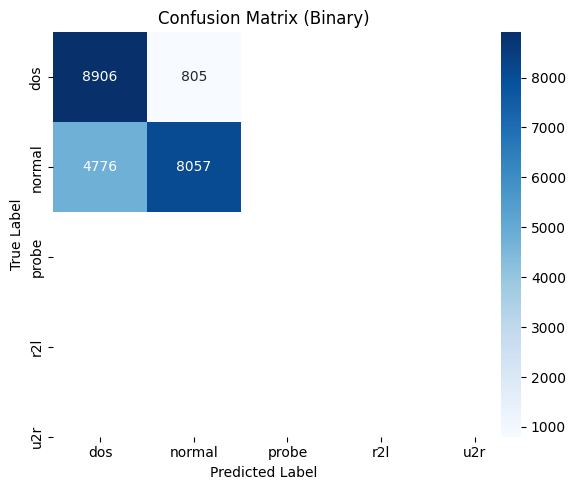

2025-05-14 03:49:36,428 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:36,429 - INFO - --- Starting Epoch 2/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:36,526 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:36,528 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:36,529 - DEBUG - Finished Postprocessing: N=509, B=256, x=torch.Size([509, 118]), Added y=torch.Size([256]), t=torch.Size([509])
2025-05-14 03:49:36,529 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:36,531 - DEBUG - TGAT Fwd Start: N=509, B=256, x=torch.Size([509, 118])
2025-05-14 03:49:36,532 - DEBUG -   Init h shape: torch.Size([509, 256])
2025-05-14 03:49:36,535 - DEBUG -   After Layer 0: h shape=torch.Size([509, 256])
2025-05-14 03:49:36,537 - DEBUG -   After Layer 1: h shape=torch.Size([509, 256])
2025-05-14 03:49:36,537 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:36,538 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:36,551 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:38,535 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:38,538 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:38,540 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:38,540 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:38,541 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:38,542 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:38,545 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:38,548 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:38,549 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:38,549 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:38,554 - DEBUG - P

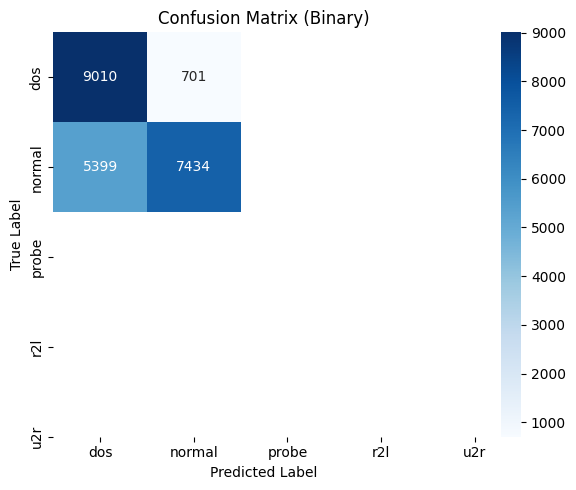

2025-05-14 03:49:39,357 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:39,358 - INFO - --- Starting Epoch 3/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:39,523 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:39,524 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:39,525 - DEBUG - Finished Postprocessing: N=510, B=256, x=torch.Size([510, 118]), Added y=torch.Size([256]), t=torch.Size([510])
2025-05-14 03:49:39,526 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:39,528 - DEBUG - TGAT Fwd Start: N=510, B=256, x=torch.Size([510, 118])
2025-05-14 03:49:39,529 - DEBUG -   Init h shape: torch.Size([510, 256])
2025-05-14 03:49:39,532 - DEBUG -   After Layer 0: h shape=torch.Size([510, 256])
2025-05-14 03:49:39,534 - DEBUG -   After Layer 1: h shape=torch.Size([510, 256])
2025-05-14 03:49:39,535 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:39,536 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:39,554 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:41,566 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:41,568 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:41,569 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:41,569 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:41,570 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:41,571 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:41,574 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:41,576 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:41,577 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:41,577 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:41,583 - DEBUG - P

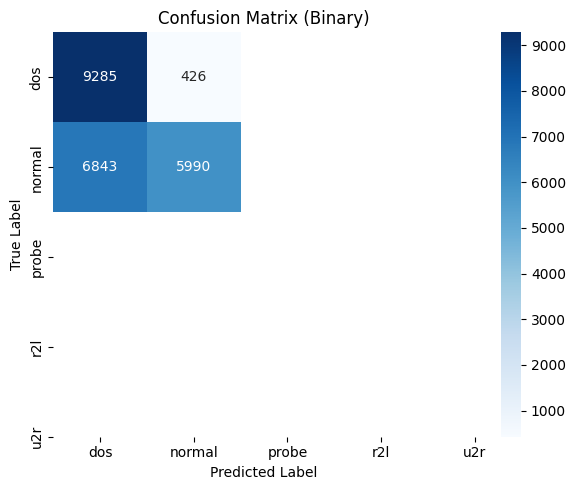

2025-05-14 03:49:42,418 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:42,419 - INFO - --- Starting Epoch 4/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:42,659 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:42,661 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:42,662 - DEBUG - Finished Postprocessing: N=509, B=256, x=torch.Size([509, 118]), Added y=torch.Size([256]), t=torch.Size([509])
2025-05-14 03:49:42,663 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:42,665 - DEBUG - TGAT Fwd Start: N=509, B=256, x=torch.Size([509, 118])
2025-05-14 03:49:42,666 - DEBUG -   Init h shape: torch.Size([509, 256])
2025-05-14 03:49:42,669 - DEBUG -   After Layer 0: h shape=torch.Size([509, 256])
2025-05-14 03:49:42,671 - DEBUG -   After Layer 1: h shape=torch.Size([509, 256])
2025-05-14 03:49:42,672 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:42,673 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:42,688 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:44,639 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:44,640 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:44,641 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:44,642 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:44,643 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:44,644 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:44,647 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:44,649 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:44,650 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:44,650 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:44,655 - DEBUG - P

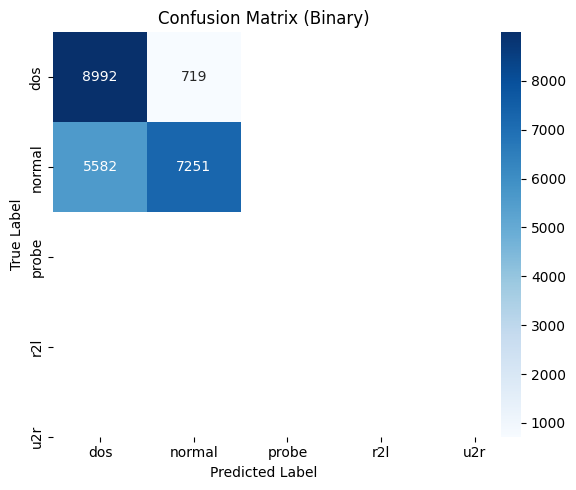

2025-05-14 03:49:45,363 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:45,363 - INFO - --- Starting Epoch 5/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:45,454 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:45,456 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:45,457 - DEBUG - Finished Postprocessing: N=511, B=256, x=torch.Size([511, 118]), Added y=torch.Size([256]), t=torch.Size([511])
2025-05-14 03:49:45,458 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:45,460 - DEBUG - TGAT Fwd Start: N=511, B=256, x=torch.Size([511, 118])
2025-05-14 03:49:45,462 - DEBUG -   Init h shape: torch.Size([511, 256])
2025-05-14 03:49:45,465 - DEBUG -   After Layer 0: h shape=torch.Size([511, 256])
2025-05-14 03:49:45,468 - DEBUG -   After Layer 1: h shape=torch.Size([511, 256])
2025-05-14 03:49:45,468 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:45,469 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:45,482 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:47,194 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:47,196 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:47,197 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:47,197 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:47,199 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:47,200 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:47,203 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:47,206 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:47,207 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:47,207 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:47,214 - DEBUG - P

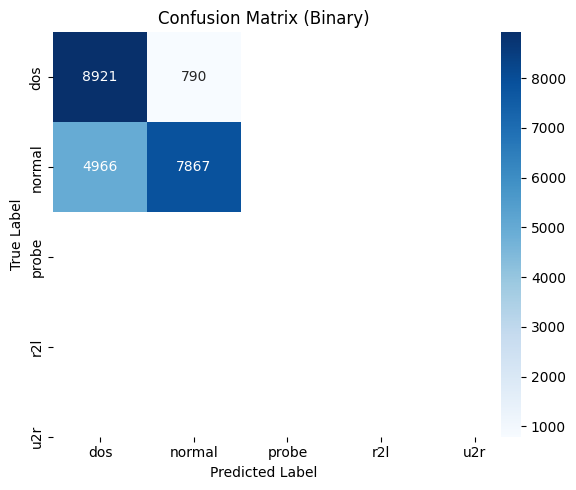

2025-05-14 03:49:48,000 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:48,001 - INFO - --- Starting Epoch 6/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:48,088 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:48,090 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:48,091 - DEBUG - Finished Postprocessing: N=508, B=256, x=torch.Size([508, 118]), Added y=torch.Size([256]), t=torch.Size([508])
2025-05-14 03:49:48,091 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:48,094 - DEBUG - TGAT Fwd Start: N=508, B=256, x=torch.Size([508, 118])
2025-05-14 03:49:48,094 - DEBUG -   Init h shape: torch.Size([508, 256])
2025-05-14 03:49:48,098 - DEBUG -   After Layer 0: h shape=torch.Size([508, 256])
2025-05-14 03:49:48,100 - DEBUG -   After Layer 1: h shape=torch.Size([508, 256])
2025-05-14 03:49:48,100 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:48,101 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:48,203 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:50,472 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:50,474 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:50,475 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:50,475 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:50,477 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:50,478 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:50,481 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:50,484 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:50,484 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:50,485 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:50,489 - DEBUG - P

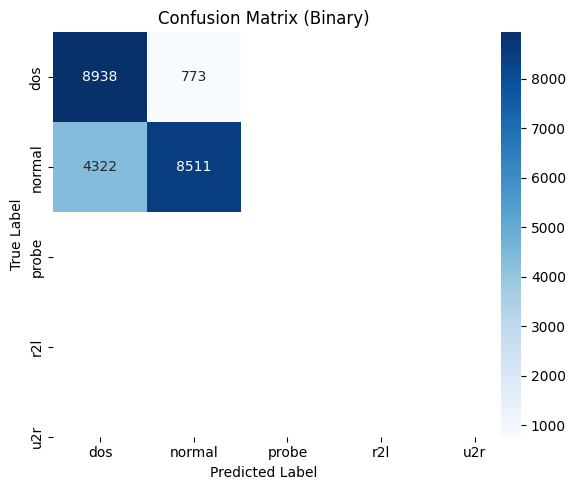

2025-05-14 03:49:51,253 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:51,254 - INFO - --- Starting Epoch 7/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:51,459 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:51,460 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:51,461 - DEBUG - Finished Postprocessing: N=508, B=256, x=torch.Size([508, 118]), Added y=torch.Size([256]), t=torch.Size([508])
2025-05-14 03:49:51,462 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:51,464 - DEBUG - TGAT Fwd Start: N=508, B=256, x=torch.Size([508, 118])
2025-05-14 03:49:51,465 - DEBUG -   Init h shape: torch.Size([508, 256])
2025-05-14 03:49:51,469 - DEBUG -   After Layer 0: h shape=torch.Size([508, 256])
2025-05-14 03:49:51,471 - DEBUG -   After Layer 1: h shape=torch.Size([508, 256])
2025-05-14 03:49:51,473 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:51,474 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:51,486 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:54,371 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:54,373 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:54,374 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:54,374 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:54,376 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:54,377 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:54,379 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:54,382 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:54,383 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:54,384 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:54,393 - DEBUG - P

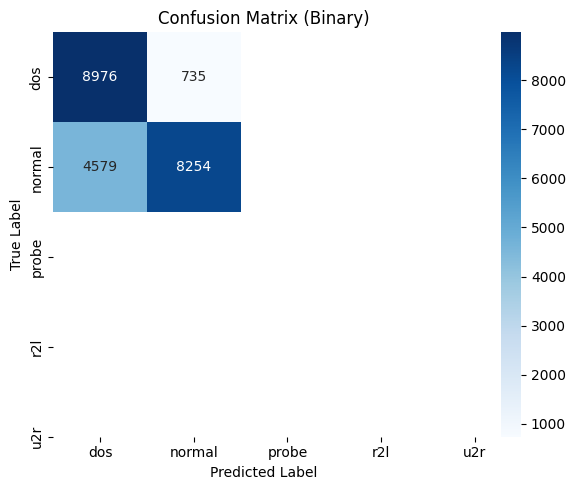

2025-05-14 03:49:55,137 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:55,138 - INFO - --- Starting Epoch 8/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:55,455 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:55,457 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:55,459 - DEBUG - Finished Postprocessing: N=511, B=256, x=torch.Size([511, 118]), Added y=torch.Size([256]), t=torch.Size([511])
2025-05-14 03:49:55,459 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:55,461 - DEBUG - TGAT Fwd Start: N=511, B=256, x=torch.Size([511, 118])
2025-05-14 03:49:55,462 - DEBUG -   Init h shape: torch.Size([511, 256])
2025-05-14 03:49:55,465 - DEBUG -   After Layer 0: h shape=torch.Size([511, 256])
2025-05-14 03:49:55,468 - DEBUG -   After Layer 1: h shape=torch.Size([511, 256])
2025-05-14 03:49:55,468 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:55,469 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:55,479 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:49:57,527 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:57,528 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:57,529 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:49:57,529 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:57,530 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:49:57,531 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:49:57,534 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:49:57,535 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:49:57,536 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:49:57,536 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:49:57,542 - DEBUG - P

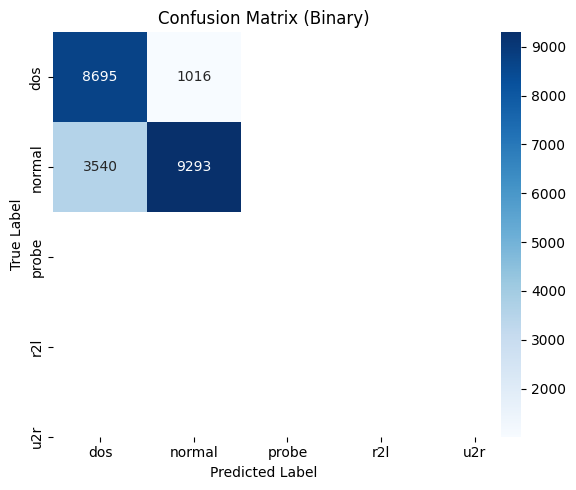

2025-05-14 03:49:58,209 - INFO - --- Evaluation Complete ---
2025-05-14 03:49:58,210 - INFO - --- Starting Epoch 9/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:49:58,299 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:49:58,300 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:49:58,301 - DEBUG - Finished Postprocessing: N=506, B=256, x=torch.Size([506, 118]), Added y=torch.Size([256]), t=torch.Size([506])
2025-05-14 03:49:58,302 - DEBUG - Yielding processed batch 0
2025-05-14 03:49:58,304 - DEBUG - TGAT Fwd Start: N=506, B=256, x=torch.Size([506, 118])
2025-05-14 03:49:58,305 - DEBUG -   Init h shape: torch.Size([506, 256])
2025-05-14 03:49:58,307 - DEBUG -   After Layer 0: h shape=torch.Size([506, 256])
2025-05-14 03:49:58,310 - DEBUG -   After Layer 1: h shape=torch.Size([506, 256])
2025-05-14 03:49:58,310 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:49:58,311 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:49:58,320 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:00,035 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:00,036 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:00,037 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:00,037 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:00,039 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:00,039 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:00,042 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:00,044 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:00,045 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:00,045 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:00,051 - DEBUG - P

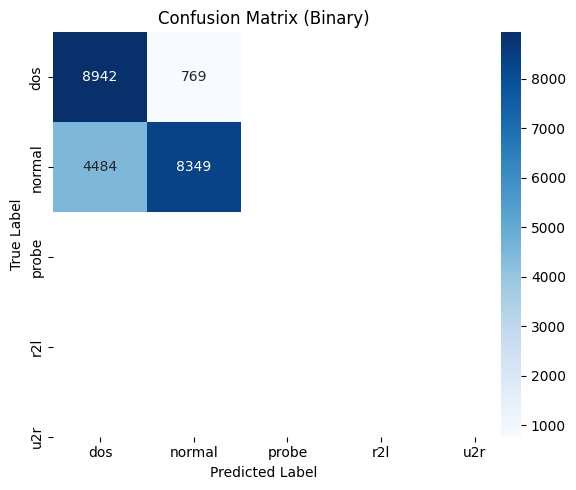

2025-05-14 03:50:00,763 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:00,764 - INFO - --- Starting Epoch 10/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:00,875 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:00,876 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:00,877 - DEBUG - Finished Postprocessing: N=512, B=256, x=torch.Size([512, 118]), Added y=torch.Size([256]), t=torch.Size([512])
2025-05-14 03:50:00,878 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:00,880 - DEBUG - TGAT Fwd Start: N=512, B=256, x=torch.Size([512, 118])
2025-05-14 03:50:00,880 - DEBUG -   Init h shape: torch.Size([512, 256])
2025-05-14 03:50:00,883 - DEBUG -   After Layer 0: h shape=torch.Size([512, 256])
2025-05-14 03:50:00,885 - DEBUG -   After Layer 1: h shape=torch.Size([512, 256])
2025-05-14 03:50:00,886 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:00,886 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:00,898 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:02,638 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:02,640 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:02,641 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:02,642 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:02,643 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:02,644 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:02,647 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:02,649 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:02,649 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:02,650 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:02,657 - DEBUG - P

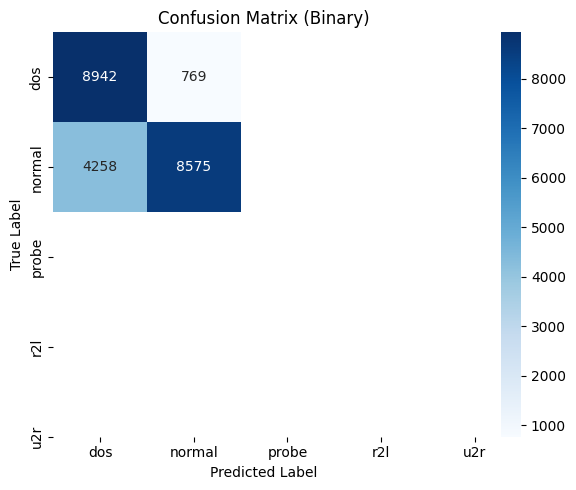

2025-05-14 03:50:03,423 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:03,424 - INFO - --- Starting Epoch 11/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:03,563 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:03,564 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:03,565 - DEBUG - Finished Postprocessing: N=507, B=256, x=torch.Size([507, 118]), Added y=torch.Size([256]), t=torch.Size([507])
2025-05-14 03:50:03,566 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:03,568 - DEBUG - TGAT Fwd Start: N=507, B=256, x=torch.Size([507, 118])
2025-05-14 03:50:03,569 - DEBUG -   Init h shape: torch.Size([507, 256])
2025-05-14 03:50:03,572 - DEBUG -   After Layer 0: h shape=torch.Size([507, 256])
2025-05-14 03:50:03,574 - DEBUG -   After Layer 1: h shape=torch.Size([507, 256])
2025-05-14 03:50:03,575 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:03,576 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:03,590 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:05,542 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:05,544 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:05,545 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:05,545 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:05,546 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:05,547 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:05,549 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:05,551 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:05,552 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:05,552 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:05,557 - DEBUG - P

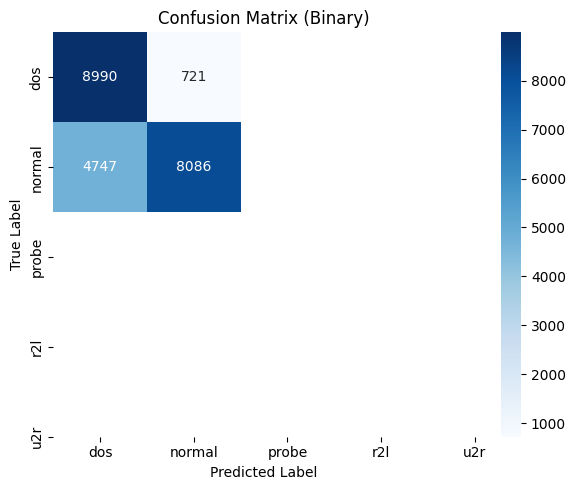

2025-05-14 03:50:06,232 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:06,233 - INFO - --- Starting Epoch 12/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:06,414 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:06,416 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:06,417 - DEBUG - Finished Postprocessing: N=511, B=256, x=torch.Size([511, 118]), Added y=torch.Size([256]), t=torch.Size([511])
2025-05-14 03:50:06,417 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:06,420 - DEBUG - TGAT Fwd Start: N=511, B=256, x=torch.Size([511, 118])
2025-05-14 03:50:06,421 - DEBUG -   Init h shape: torch.Size([511, 256])
2025-05-14 03:50:06,424 - DEBUG -   After Layer 0: h shape=torch.Size([511, 256])
2025-05-14 03:50:06,427 - DEBUG -   After Layer 1: h shape=torch.Size([511, 256])
2025-05-14 03:50:06,427 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:06,428 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:06,438 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:08,214 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:08,215 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:08,216 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:08,217 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:08,218 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:08,219 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:08,222 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:08,224 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:08,225 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:08,226 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:08,234 - DEBUG - P

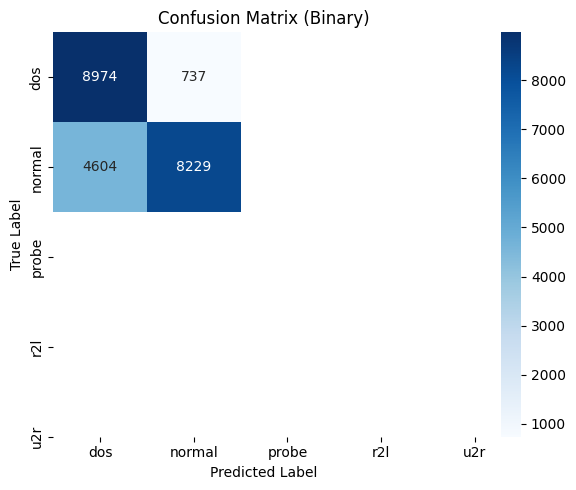

2025-05-14 03:50:08,926 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:08,927 - INFO - --- Starting Epoch 13/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:09,022 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:09,024 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:09,028 - DEBUG - Finished Postprocessing: N=509, B=256, x=torch.Size([509, 118]), Added y=torch.Size([256]), t=torch.Size([509])
2025-05-14 03:50:09,028 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:09,030 - DEBUG - TGAT Fwd Start: N=509, B=256, x=torch.Size([509, 118])
2025-05-14 03:50:09,031 - DEBUG -   Init h shape: torch.Size([509, 256])
2025-05-14 03:50:09,035 - DEBUG -   After Layer 0: h shape=torch.Size([509, 256])
2025-05-14 03:50:09,038 - DEBUG -   After Layer 1: h shape=torch.Size([509, 256])
2025-05-14 03:50:09,038 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:09,039 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:09,054 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:11,284 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:11,286 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:11,288 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:11,288 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:11,290 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:11,291 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:11,294 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:11,296 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:11,297 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:11,298 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:11,303 - DEBUG - P

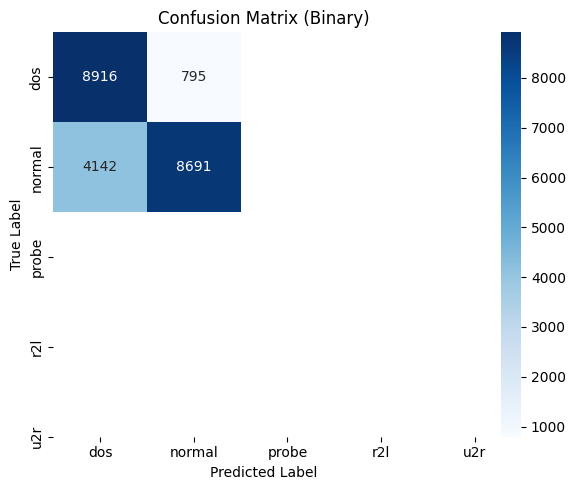

2025-05-14 03:50:12,262 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:12,263 - INFO - --- Starting Epoch 14/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:12,383 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:12,384 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:12,386 - DEBUG - Finished Postprocessing: N=509, B=256, x=torch.Size([509, 118]), Added y=torch.Size([256]), t=torch.Size([509])
2025-05-14 03:50:12,386 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:12,388 - DEBUG - TGAT Fwd Start: N=509, B=256, x=torch.Size([509, 118])
2025-05-14 03:50:12,389 - DEBUG -   Init h shape: torch.Size([509, 256])
2025-05-14 03:50:12,392 - DEBUG -   After Layer 0: h shape=torch.Size([509, 256])
2025-05-14 03:50:12,395 - DEBUG -   After Layer 1: h shape=torch.Size([509, 256])
2025-05-14 03:50:12,396 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:12,396 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:12,409 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:14,219 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:14,220 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:14,221 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:14,221 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:14,222 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:14,223 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:14,226 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:14,228 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:14,229 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:14,229 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:14,233 - DEBUG - P

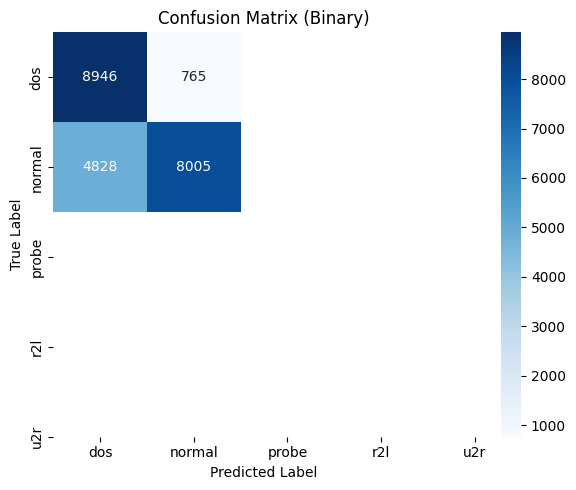

2025-05-14 03:50:14,910 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:14,911 - INFO - --- Starting Epoch 15/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:15,006 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:15,008 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:15,009 - DEBUG - Finished Postprocessing: N=508, B=256, x=torch.Size([508, 118]), Added y=torch.Size([256]), t=torch.Size([508])
2025-05-14 03:50:15,010 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:15,012 - DEBUG - TGAT Fwd Start: N=508, B=256, x=torch.Size([508, 118])
2025-05-14 03:50:15,013 - DEBUG -   Init h shape: torch.Size([508, 256])
2025-05-14 03:50:15,017 - DEBUG -   After Layer 0: h shape=torch.Size([508, 256])
2025-05-14 03:50:15,019 - DEBUG -   After Layer 1: h shape=torch.Size([508, 256])
2025-05-14 03:50:15,021 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:15,022 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:15,035 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:16,731 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:16,733 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:16,734 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:16,734 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:16,735 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:16,736 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:16,739 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:16,742 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:16,742 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:16,743 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:16,752 - DEBUG - P

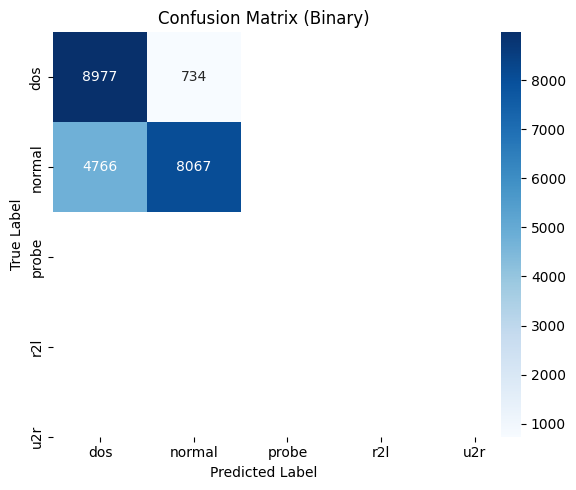

2025-05-14 03:50:17,487 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:17,488 - INFO - --- Starting Epoch 16/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:17,591 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:17,594 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:17,595 - DEBUG - Finished Postprocessing: N=507, B=256, x=torch.Size([507, 118]), Added y=torch.Size([256]), t=torch.Size([507])
2025-05-14 03:50:17,596 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:17,599 - DEBUG - TGAT Fwd Start: N=507, B=256, x=torch.Size([507, 118])
2025-05-14 03:50:17,600 - DEBUG -   Init h shape: torch.Size([507, 256])
2025-05-14 03:50:17,604 - DEBUG -   After Layer 0: h shape=torch.Size([507, 256])
2025-05-14 03:50:17,607 - DEBUG -   After Layer 1: h shape=torch.Size([507, 256])
2025-05-14 03:50:17,608 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:17,610 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:17,627 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:19,450 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:19,452 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:19,453 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:19,453 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:19,454 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:19,455 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:19,458 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:19,461 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:19,461 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:19,462 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:19,470 - DEBUG - P

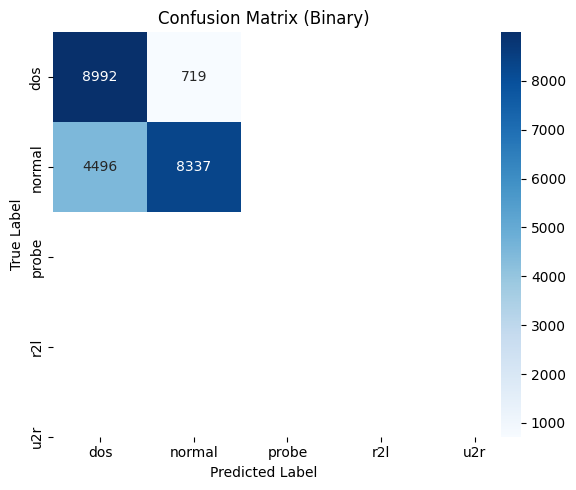

2025-05-14 03:50:20,228 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:20,229 - INFO - --- Starting Epoch 17/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:20,379 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:20,381 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:20,381 - DEBUG - Finished Postprocessing: N=511, B=256, x=torch.Size([511, 118]), Added y=torch.Size([256]), t=torch.Size([511])
2025-05-14 03:50:20,382 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:20,384 - DEBUG - TGAT Fwd Start: N=511, B=256, x=torch.Size([511, 118])
2025-05-14 03:50:20,385 - DEBUG -   Init h shape: torch.Size([511, 256])
2025-05-14 03:50:20,388 - DEBUG -   After Layer 0: h shape=torch.Size([511, 256])
2025-05-14 03:50:20,390 - DEBUG -   After Layer 1: h shape=torch.Size([511, 256])
2025-05-14 03:50:20,390 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:20,391 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:20,404 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:22,190 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:22,192 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:22,192 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:22,193 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:22,194 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:22,195 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:22,198 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:22,200 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:22,200 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:22,201 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:22,219 - DEBUG - P

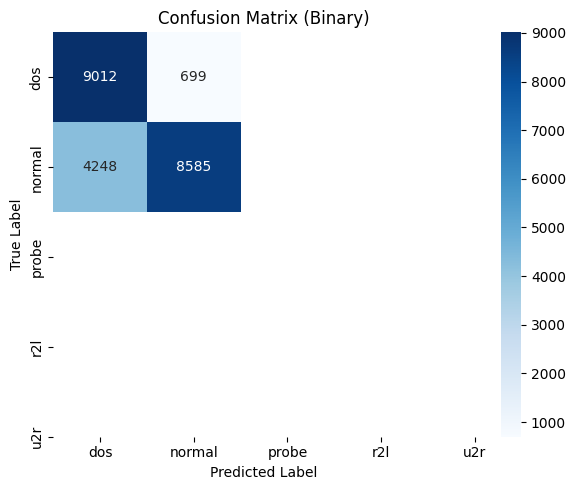

2025-05-14 03:50:22,924 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:22,925 - INFO - --- Starting Epoch 18/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:23,014 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:23,016 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:23,017 - DEBUG - Finished Postprocessing: N=509, B=256, x=torch.Size([509, 118]), Added y=torch.Size([256]), t=torch.Size([509])
2025-05-14 03:50:23,017 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:23,019 - DEBUG - TGAT Fwd Start: N=509, B=256, x=torch.Size([509, 118])
2025-05-14 03:50:23,020 - DEBUG -   Init h shape: torch.Size([509, 256])
2025-05-14 03:50:23,023 - DEBUG -   After Layer 0: h shape=torch.Size([509, 256])
2025-05-14 03:50:23,025 - DEBUG -   After Layer 1: h shape=torch.Size([509, 256])
2025-05-14 03:50:23,025 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:23,026 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:23,039 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:24,847 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:24,849 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:24,850 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:24,850 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:24,851 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:24,852 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:24,855 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:24,858 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:24,859 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:24,860 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:24,868 - DEBUG - P

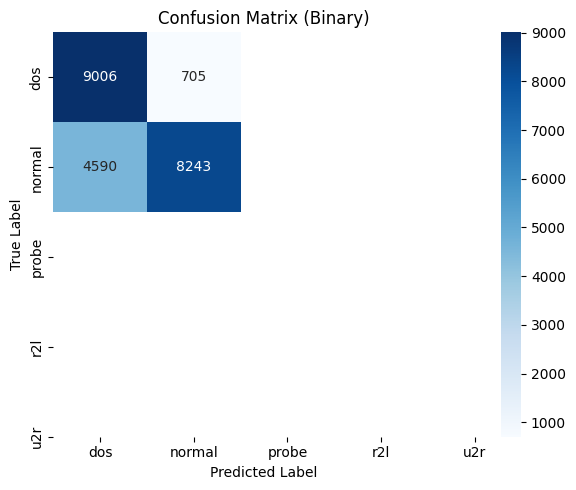

2025-05-14 03:50:25,703 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:25,704 - INFO - --- Starting Epoch 19/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:25,815 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:25,816 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:25,817 - DEBUG - Finished Postprocessing: N=511, B=256, x=torch.Size([511, 118]), Added y=torch.Size([256]), t=torch.Size([511])
2025-05-14 03:50:25,818 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:25,820 - DEBUG - TGAT Fwd Start: N=511, B=256, x=torch.Size([511, 118])
2025-05-14 03:50:25,821 - DEBUG -   Init h shape: torch.Size([511, 256])
2025-05-14 03:50:25,824 - DEBUG -   After Layer 0: h shape=torch.Size([511, 256])
2025-05-14 03:50:25,826 - DEBUG -   After Layer 1: h shape=torch.Size([511, 256])
2025-05-14 03:50:25,827 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:25,827 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:25,839 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:28,060 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:28,062 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:28,063 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:28,064 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:28,066 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:28,067 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:28,071 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:28,073 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:28,074 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:28,075 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:28,081 - DEBUG - P

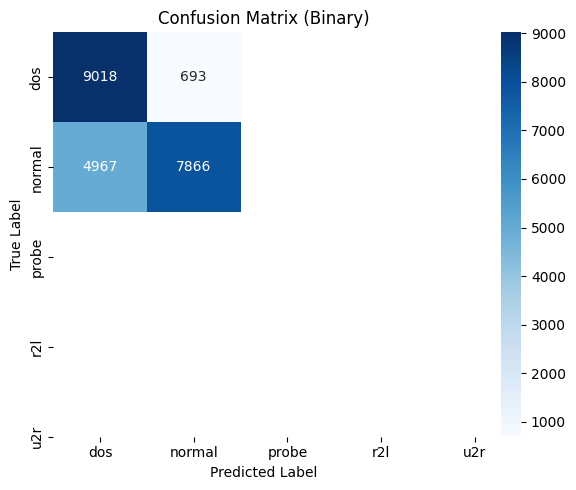

2025-05-14 03:50:29,064 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:29,065 - INFO - --- Starting Epoch 20/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:29,254 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:29,256 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:29,257 - DEBUG - Finished Postprocessing: N=511, B=256, x=torch.Size([511, 118]), Added y=torch.Size([256]), t=torch.Size([511])
2025-05-14 03:50:29,258 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:29,260 - DEBUG - TGAT Fwd Start: N=511, B=256, x=torch.Size([511, 118])
2025-05-14 03:50:29,261 - DEBUG -   Init h shape: torch.Size([511, 256])
2025-05-14 03:50:29,264 - DEBUG -   After Layer 0: h shape=torch.Size([511, 256])
2025-05-14 03:50:29,267 - DEBUG -   After Layer 1: h shape=torch.Size([511, 256])
2025-05-14 03:50:29,267 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:29,268 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:29,278 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:31,314 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:31,316 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:31,316 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:31,317 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:31,318 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:31,319 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:31,322 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:31,324 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:31,324 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:31,325 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:31,329 - DEBUG - P

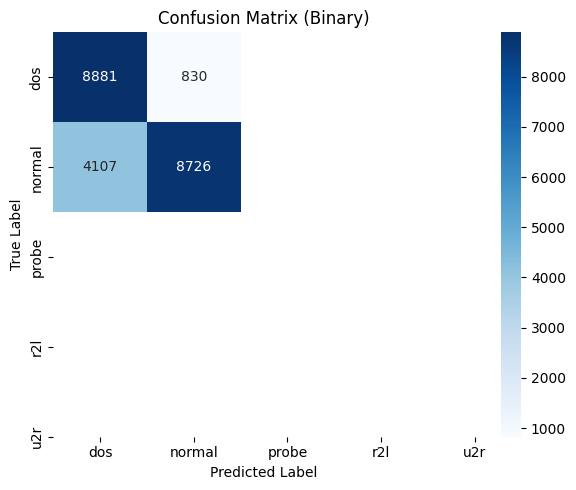

2025-05-14 03:50:32,098 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:32,099 - INFO - --- Starting Epoch 21/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:32,215 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:32,217 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:32,218 - DEBUG - Finished Postprocessing: N=509, B=256, x=torch.Size([509, 118]), Added y=torch.Size([256]), t=torch.Size([509])
2025-05-14 03:50:32,218 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:32,220 - DEBUG - TGAT Fwd Start: N=509, B=256, x=torch.Size([509, 118])
2025-05-14 03:50:32,222 - DEBUG -   Init h shape: torch.Size([509, 256])
2025-05-14 03:50:32,225 - DEBUG -   After Layer 0: h shape=torch.Size([509, 256])
2025-05-14 03:50:32,228 - DEBUG -   After Layer 1: h shape=torch.Size([509, 256])
2025-05-14 03:50:32,228 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:32,229 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:32,247 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:34,122 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:34,124 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:34,125 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:34,126 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:34,127 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:34,128 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:34,131 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:34,133 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:34,134 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:34,134 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:34,142 - DEBUG - P

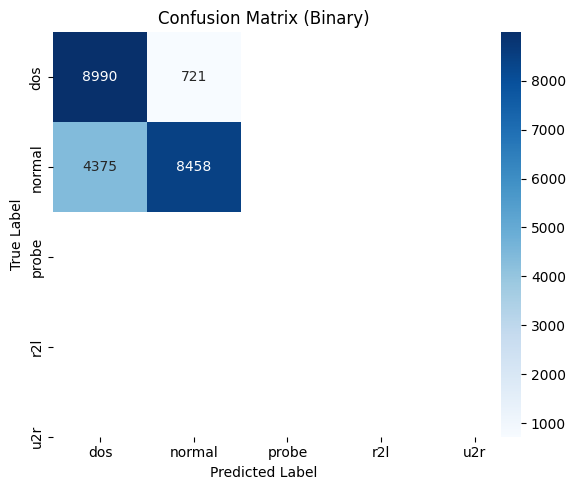

2025-05-14 03:50:34,939 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:34,940 - INFO - --- Starting Epoch 22/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:35,084 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:35,085 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:35,087 - DEBUG - Finished Postprocessing: N=511, B=256, x=torch.Size([511, 118]), Added y=torch.Size([256]), t=torch.Size([511])
2025-05-14 03:50:35,087 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:35,090 - DEBUG - TGAT Fwd Start: N=511, B=256, x=torch.Size([511, 118])
2025-05-14 03:50:35,091 - DEBUG -   Init h shape: torch.Size([511, 256])
2025-05-14 03:50:35,094 - DEBUG -   After Layer 0: h shape=torch.Size([511, 256])
2025-05-14 03:50:35,096 - DEBUG -   After Layer 1: h shape=torch.Size([511, 256])
2025-05-14 03:50:35,097 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:35,098 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:35,111 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:37,100 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:37,101 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:37,102 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:37,103 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:37,104 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:37,105 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:37,108 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:37,111 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:37,111 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:37,112 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:37,323 - DEBUG - P

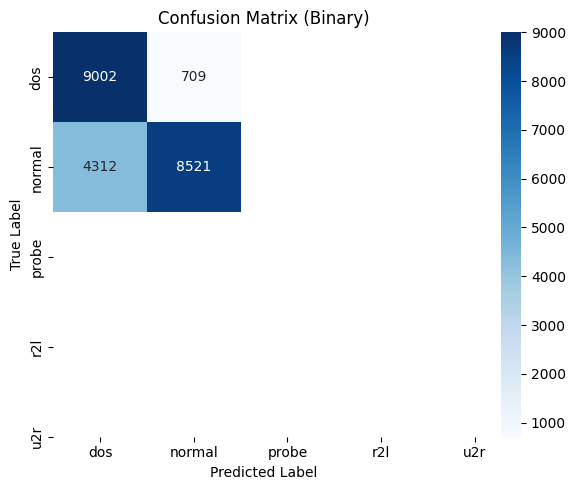

2025-05-14 03:50:38,182 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:38,182 - INFO - --- Starting Epoch 23/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:38,307 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:38,309 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:38,311 - DEBUG - Finished Postprocessing: N=508, B=256, x=torch.Size([508, 118]), Added y=torch.Size([256]), t=torch.Size([508])
2025-05-14 03:50:38,312 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:38,314 - DEBUG - TGAT Fwd Start: N=508, B=256, x=torch.Size([508, 118])
2025-05-14 03:50:38,315 - DEBUG -   Init h shape: torch.Size([508, 256])
2025-05-14 03:50:38,319 - DEBUG -   After Layer 0: h shape=torch.Size([508, 256])
2025-05-14 03:50:38,321 - DEBUG -   After Layer 1: h shape=torch.Size([508, 256])
2025-05-14 03:50:38,322 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:38,323 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:38,337 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:40,314 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:40,316 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:40,317 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:40,317 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:40,318 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:40,319 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:40,322 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:40,324 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:40,325 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:40,326 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:40,334 - DEBUG - P

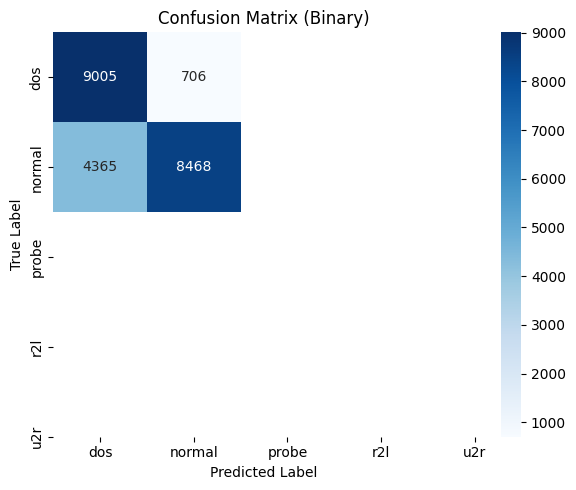

2025-05-14 03:50:41,162 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:41,163 - INFO - --- Starting Epoch 24/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:41,339 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:41,340 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:41,341 - DEBUG - Finished Postprocessing: N=508, B=256, x=torch.Size([508, 118]), Added y=torch.Size([256]), t=torch.Size([508])
2025-05-14 03:50:41,342 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:41,344 - DEBUG - TGAT Fwd Start: N=508, B=256, x=torch.Size([508, 118])
2025-05-14 03:50:41,345 - DEBUG -   Init h shape: torch.Size([508, 256])
2025-05-14 03:50:41,348 - DEBUG -   After Layer 0: h shape=torch.Size([508, 256])
2025-05-14 03:50:41,350 - DEBUG -   After Layer 1: h shape=torch.Size([508, 256])
2025-05-14 03:50:41,351 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:41,351 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:41,475 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:43,691 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:43,693 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:43,694 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:43,694 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:43,695 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:43,696 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:43,699 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:43,701 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:43,702 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:43,702 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:43,706 - DEBUG - P

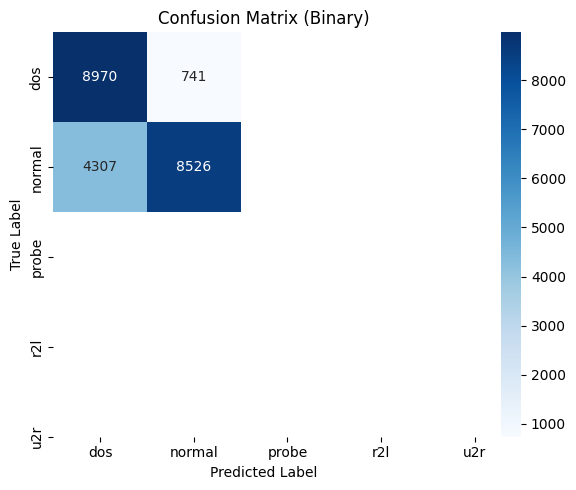

2025-05-14 03:50:44,508 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:44,509 - INFO - --- Starting Epoch 25/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:44,742 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:44,744 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:44,745 - DEBUG - Finished Postprocessing: N=509, B=256, x=torch.Size([509, 118]), Added y=torch.Size([256]), t=torch.Size([509])
2025-05-14 03:50:44,746 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:44,748 - DEBUG - TGAT Fwd Start: N=509, B=256, x=torch.Size([509, 118])
2025-05-14 03:50:44,749 - DEBUG -   Init h shape: torch.Size([509, 256])
2025-05-14 03:50:44,752 - DEBUG -   After Layer 0: h shape=torch.Size([509, 256])
2025-05-14 03:50:44,754 - DEBUG -   After Layer 1: h shape=torch.Size([509, 256])
2025-05-14 03:50:44,755 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:44,756 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:44,766 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:46,663 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:46,665 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:46,666 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:46,667 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:46,668 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:46,669 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:46,672 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:46,675 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:46,675 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:46,676 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:46,680 - DEBUG - P

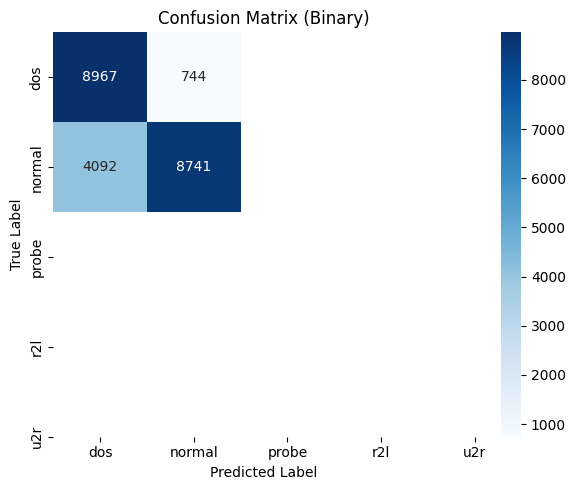

2025-05-14 03:50:47,477 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:47,478 - INFO - --- Starting Epoch 26/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:47,759 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:47,761 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:47,763 - DEBUG - Finished Postprocessing: N=512, B=256, x=torch.Size([512, 118]), Added y=torch.Size([256]), t=torch.Size([512])
2025-05-14 03:50:47,763 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:47,766 - DEBUG - TGAT Fwd Start: N=512, B=256, x=torch.Size([512, 118])
2025-05-14 03:50:47,767 - DEBUG -   Init h shape: torch.Size([512, 256])
2025-05-14 03:50:47,772 - DEBUG -   After Layer 0: h shape=torch.Size([512, 256])
2025-05-14 03:50:47,776 - DEBUG -   After Layer 1: h shape=torch.Size([512, 256])
2025-05-14 03:50:47,777 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:47,778 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:47,794 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:49,699 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:49,701 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:49,702 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:49,703 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:49,704 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:49,709 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:49,713 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:49,716 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:49,717 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:49,717 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:49,724 - DEBUG - P

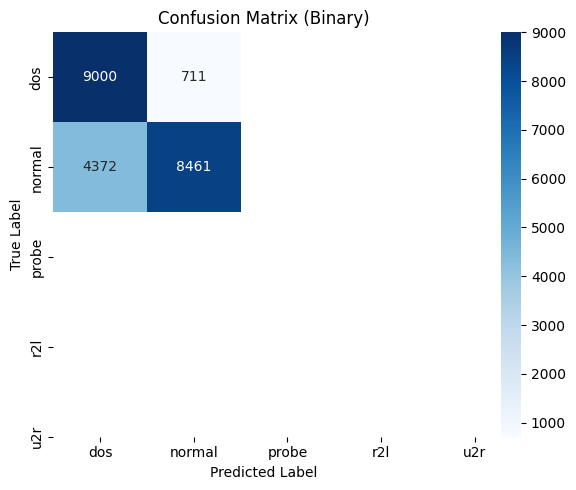

2025-05-14 03:50:50,473 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:50,474 - INFO - --- Starting Epoch 27/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:50,750 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:50,752 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:50,754 - DEBUG - Finished Postprocessing: N=510, B=256, x=torch.Size([510, 118]), Added y=torch.Size([256]), t=torch.Size([510])
2025-05-14 03:50:50,755 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:50,757 - DEBUG - TGAT Fwd Start: N=510, B=256, x=torch.Size([510, 118])
2025-05-14 03:50:50,758 - DEBUG -   Init h shape: torch.Size([510, 256])
2025-05-14 03:50:50,762 - DEBUG -   After Layer 0: h shape=torch.Size([510, 256])
2025-05-14 03:50:50,764 - DEBUG -   After Layer 1: h shape=torch.Size([510, 256])
2025-05-14 03:50:50,765 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:50,766 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:50,779 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:52,923 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:52,925 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:52,926 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:52,926 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:52,928 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:52,928 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:52,931 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:52,933 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:52,934 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:52,935 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:52,972 - DEBUG - P

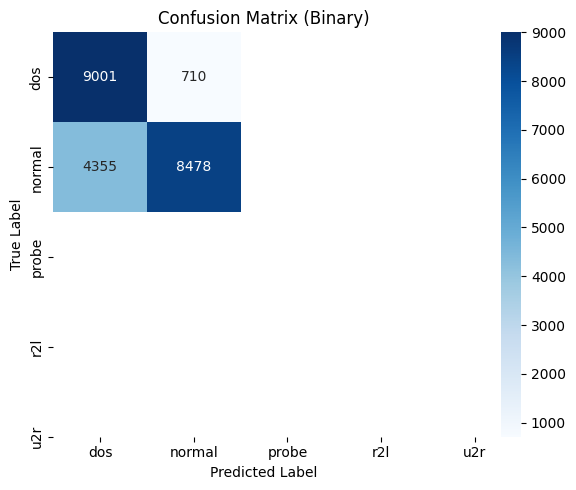

2025-05-14 03:50:53,818 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:53,818 - INFO - --- Starting Epoch 28/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:53,951 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:53,953 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:53,954 - DEBUG - Finished Postprocessing: N=510, B=256, x=torch.Size([510, 118]), Added y=torch.Size([256]), t=torch.Size([510])
2025-05-14 03:50:53,955 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:53,957 - DEBUG - TGAT Fwd Start: N=510, B=256, x=torch.Size([510, 118])
2025-05-14 03:50:53,958 - DEBUG -   Init h shape: torch.Size([510, 256])
2025-05-14 03:50:53,961 - DEBUG -   After Layer 0: h shape=torch.Size([510, 256])
2025-05-14 03:50:53,963 - DEBUG -   After Layer 1: h shape=torch.Size([510, 256])
2025-05-14 03:50:53,964 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:53,965 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:53,977 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:56,124 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:56,126 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:56,127 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:56,127 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:56,129 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:56,130 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:56,133 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:56,135 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:56,135 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:56,136 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:56,227 - DEBUG - P

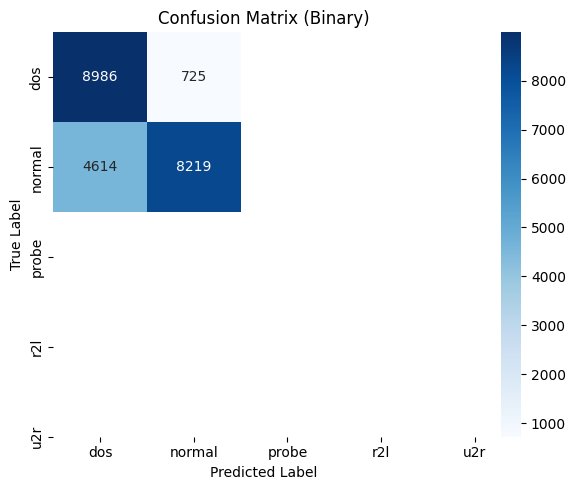

2025-05-14 03:50:56,944 - INFO - --- Evaluation Complete ---
2025-05-14 03:50:56,945 - INFO - --- Starting Epoch 29/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:50:57,183 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:57,185 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:57,186 - DEBUG - Finished Postprocessing: N=512, B=256, x=torch.Size([512, 118]), Added y=torch.Size([256]), t=torch.Size([512])
2025-05-14 03:50:57,186 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:57,189 - DEBUG - TGAT Fwd Start: N=512, B=256, x=torch.Size([512, 118])
2025-05-14 03:50:57,190 - DEBUG -   Init h shape: torch.Size([512, 256])
2025-05-14 03:50:57,194 - DEBUG -   After Layer 0: h shape=torch.Size([512, 256])
2025-05-14 03:50:57,196 - DEBUG -   After Layer 1: h shape=torch.Size([512, 256])
2025-05-14 03:50:57,197 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:50:57,197 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:50:57,210 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:50:59,367 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:50:59,369 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:50:59,369 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:50:59,370 - DEBUG - Yielding processed batch 0
2025-05-14 03:50:59,371 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:50:59,372 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:50:59,375 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:50:59,377 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:50:59,378 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:50:59,378 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:50:59,387 - DEBUG - P

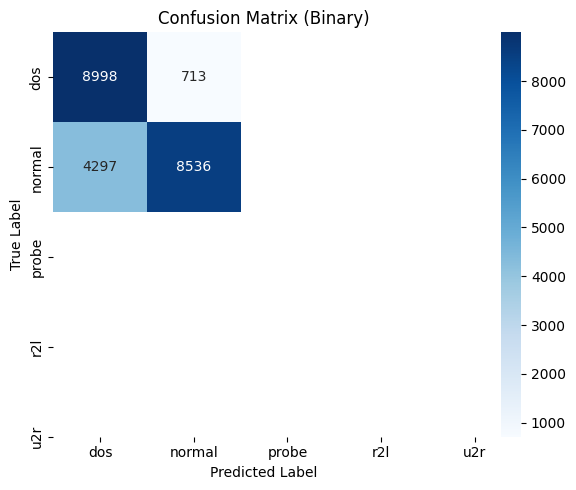

2025-05-14 03:51:00,319 - INFO - --- Evaluation Complete ---
2025-05-14 03:51:00,320 - INFO - --- Starting Epoch 30/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:51:00,521 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:51:00,523 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:51:00,524 - DEBUG - Finished Postprocessing: N=510, B=256, x=torch.Size([510, 118]), Added y=torch.Size([256]), t=torch.Size([510])
2025-05-14 03:51:00,525 - DEBUG - Yielding processed batch 0
2025-05-14 03:51:00,527 - DEBUG - TGAT Fwd Start: N=510, B=256, x=torch.Size([510, 118])
2025-05-14 03:51:00,528 - DEBUG -   Init h shape: torch.Size([510, 256])
2025-05-14 03:51:00,532 - DEBUG -   After Layer 0: h shape=torch.Size([510, 256])
2025-05-14 03:51:00,534 - DEBUG -   After Layer 1: h shape=torch.Size([510, 256])
2025-05-14 03:51:00,535 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:51:00,535 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:51:00,559 - DEBUG - P

Evaluating (Event Nodes):   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-14 03:51:02,551 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:51:02,553 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:51:02,554 - DEBUG - Finished Postprocessing: N=513, B=512, x=torch.Size([513, 118]), Added y=torch.Size([512]), t=torch.Size([513])
2025-05-14 03:51:02,555 - DEBUG - Yielding processed batch 0
2025-05-14 03:51:02,556 - DEBUG - TGAT Fwd Start: N=513, B=512, x=torch.Size([513, 118])
2025-05-14 03:51:02,557 - DEBUG -   Init h shape: torch.Size([513, 256])
2025-05-14 03:51:02,560 - DEBUG -   After Layer 0: h shape=torch.Size([513, 256])
2025-05-14 03:51:02,562 - DEBUG -   After Layer 1: h shape=torch.Size([513, 256])
2025-05-14 03:51:02,563 - DEBUG -   Extracted targets shape: torch.Size([512, 256])
2025-05-14 03:51:02,564 - DEBUG -   Final proj output shape: torch.Size([512, 1])
2025-05-14 03:51:02,731 - DEBUG - P

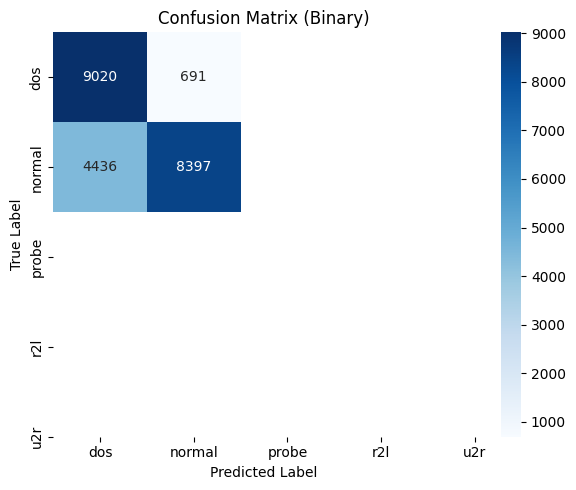

2025-05-14 03:51:03,581 - INFO - --- Evaluation Complete ---
2025-05-14 03:51:03,581 - INFO - --- Starting Epoch 31/50 ---


Training Epoch (Event Nodes):   0%|          | 0/99 [00:00<?, ?it/s]

2025-05-14 03:51:03,691 - DEBUG - Processing batch 0 from parent loader.
2025-05-14 03:51:03,692 - DEBUG - Postprocessing batch: Contains keys: ['num_nodes', 'edge_index', 'n_id', 't', 'x', 'input_id', 'num_sampled_nodes', 'e_id', 'num_sampled_edges', 'batch_size']
2025-05-14 03:51:03,693 - DEBUG - Finished Postprocessing: N=510, B=256, x=torch.Size([510, 118]), Added y=torch.Size([256]), t=torch.Size([510])
2025-05-14 03:51:03,693 - DEBUG - Yielding processed batch 0
2025-05-14 03:51:03,695 - DEBUG - TGAT Fwd Start: N=510, B=256, x=torch.Size([510, 118])
2025-05-14 03:51:03,696 - DEBUG -   Init h shape: torch.Size([510, 256])
2025-05-14 03:51:03,700 - DEBUG -   After Layer 0: h shape=torch.Size([510, 256])
2025-05-14 03:51:03,702 - DEBUG -   After Layer 1: h shape=torch.Size([510, 256])
2025-05-14 03:51:03,703 - DEBUG -   Extracted targets shape: torch.Size([256, 256])
2025-05-14 03:51:03,703 - DEBUG -   Final proj output shape: torch.Size([256, 1])
2025-05-14 03:51:03,712 - DEBUG - P

In [ ]:
# --- Main Execution (Event as Node) ---
import torch
import logging
# Make sure TemporalNeighborLoader, TGAT, etc. are defined above

# Ensure global variables are accessible or passed appropriately
# Define whether to run binary or multi-class
RUN_BINARY_CLASSIFICATION = True # Set to False for multi-class attack type prediction

def run_pipeline_event_node():
    task_type = "Binary" if RUN_BINARY_CLASSIFICATION else "Multi-class"
    logging.info(f"Starting TGAT NIDS Pipeline Execution (Event as Node, {task_type})...")

    global DEVICE, NODE_FEAT_DIM, EDGE_FEAT_DIM, NUM_CLASSES, LEARNING_RATE, EPOCHS, BATCH_SIZE
    global NUM_NEIGHBORS, THRESHOLD, TIME_DIM, N_HEADS, N_LAYERS, DROPOUT, HIDDEN_DIM

    # 1. Load and preprocess data (Event as Node)
    try:
        logging.info("Step 1: Loading and Preprocessing Data (Event as Node)")
        # Call the revised pipeline function
        data, preprocessor, label_encoder = load_and_preprocess_data_event_node_pipeline(
            use_binary_classification=RUN_BINARY_CLASSIFICATION
        )
        # Global variables NODE_FEAT_DIM, NUM_CLASSES, EDGE_FEAT_DIM should be updated now
        if NODE_FEAT_DIM is None or NUM_CLASSES is None or EDGE_FEAT_DIM is None:
             raise ValueError("NODE_FEAT_DIM, NUM_CLASSES, or EDGE_FEAT_DIM not set.")
        logging.info("Data loading and preprocessing complete.")

    except Exception as e:
        logging.error(f"Data processing stage failed: {e}", exc_info=True)
        return

    # 2. Initialize model
    try:
        logging.info("Step 2: Initializing TGAT Model (Event as Node)")
        # Output dim depends on the task
        model_output_dim = 1 if RUN_BINARY_CLASSIFICATION else NUM_CLASSES

        model = TGAT(
            num_nodes=data.num_nodes, # Total number of events is num_nodes
            node_feat_dim=NODE_FEAT_DIM, # Features per event
            # edge_feat_dim=EDGE_FEAT_DIM, # Pass edge dim if defined, else 0
            time_dim=TIME_DIM,
            output_dim=model_output_dim, # Predict 1 logit for binary, N classes for multi
            n_layers=N_LAYERS,
            n_heads=N_HEADS,
            dropout=DROPOUT,
            hidden_dim=HIDDEN_DIM
        ).to(DEVICE)
        logging.info(f"Model initialized for {task_type} classification.")
    except Exception as e:
        logging.error(f"Model initialization failed: {e}", exc_info=True)
        return

    # 3. Train model using TemporalNeighborLoader (adapted)
    try:
        logging.info("Step 3: Training Model (Using TemporalNeighborLoader for Event Nodes)")
        # Attach label encoder to data object for easy access in evaluation
        data.label_encoder = label_encoder
        trained_model = train_model_event_node(
            model,
            data,
            evaluate_fn=evaluate_model_event_node # Pass the correct evaluation function
        )
        if trained_model is None:
             logging.error("Model training failed.")
             return
        logging.info("Model training finished.")
    except Exception as e:
        logging.error(f"Model training stage failed: {e}", exc_info=True)
        return

    # 4. Final Evaluate model on Test Set
    try:
        logging.info("Step 4: Evaluating Model on Test Set (Event as Node)")
        # Recreate eval loader for final evaluation
        test_input_nodes = data.test_mask.nonzero(as_tuple=False).view(-1)
        if len(test_input_nodes) > 0:
            final_eval_loader = TemporalNeighborLoader(
                 data.cpu(),
                 batch_size=BATCH_SIZE * 2,
                 num_neighbors=NUM_NEIGHBORS,
                 replace=False,
                 directed=True,
                 input_nodes=test_input_nodes,
                 shuffle=False
             )

            results = evaluate_model_event_node(
                 trained_model,
                 final_eval_loader,
                 DEVICE,
                 NUM_CLASSES,
                 class_names=list(label_encoder.classes_),
                 use_binary_classification=RUN_BINARY_CLASSIFICATION
             )
            if results is not None:
                logging.info("Final Evaluation Results:\n" + results.to_string())
            else:
                logging.warning("Final evaluation did not produce results.")
        else:
            logging.warning("No test samples found based on mask.")

    except Exception as e:
        logging.error(f"Model final evaluation stage failed: {e}", exc_info=True)
        return

    logging.info(f"TGAT NIDS Pipeline Execution Finished (Event as Node, {task_type}).")

# --- 執行流程 ---
run_pipeline_event_node()

